In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#import matplotlib

import pandas as pd
import numpy as np
import durationpy
import math
from os.path import join
from collections import defaultdict


In [2]:
plt.style.use('ggplot')

COLORS_DEFAULT ={'blue': '#348ABD', 'red': '#E24A33'}

In [3]:
pd.set_option('display.max_rows', 1000)

In [4]:
# bbox_inches:None is default behavior of plt.savefig()
# makes it easier for the chart functions in this notebook
# to maintain compatibility with chart functions in generate_report.py
# in generate_report.py, do plt.savefig(bbox_inches='tight')
# in this notebook, do plt.tight_layout()
 
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In [5]:
# conda install -c phlya adjusttext 
from adjustText import adjust_text

## csv result files directory name and file names

In [132]:
CSV_RESULT_DIR = "../benchmark_results_data"

STANDALONE_WASM_RESULT_FILE = "standalone_wasm_results.csv"
NATIVE_RESULT_FILE = "native_benchmarks.csv"
SCOUT_RESULT_FILE = "scout_bignum_benchmarks.csv"
GETH_PRECOMPILE_RESULT_FILE = "geth_precompile_benchmarks.csv"
EVM_RESULT_FILE = "evm_benchmarks.csv"




## To add a new engine, add the engine name used in the csv file to this list

In [7]:
INTERPRETER_ENGINES = ['life', 'wagon', 'wasmi', 'wabt', 'v8-interpreter', 'wasm3', 'wamr-interp', 'fizzy']
COMPILER_ENGINES = ['lifePolymerase', 'wasmtime', 'wavm', 'v8-liftoff', 'v8-turbofan', 'asmble', 'wamr-jit', 'wamr-aot']

wasm_vm_names = INTERPRETER_ENGINES + COMPILER_ENGINES

## Helper funcs

In [8]:
def toMs(secs):
    if secs < 0.001:
        μs = secs * 1000000
        return "{}μs".format(round(μs, 1))
    if secs < 0.1:
        ms = secs * 1000
        return "{}ms".format(round(ms, 1))
    elif secs < 1:
        ms = secs * 1000
        return "{}ms".format(int(round(ms, 0)))
    else:
        return "{}s".format(round(secs, 2))

In [9]:
def labelBarHeights(ax, to_ms=True, small=False, to_factor=False, lower_y_bound=True):
    labels = []
    for p in ax.patches:
        if p.get_height() == 0:
            continue
        label_val = p.get_height()
        #print("height:", p.get_height())
        y_pos = p.get_y() + label_val
        #y_offset = -10
        y_offset = 0
        y_bound = ax.get_ybound()[1]
        if y_pos > y_bound:
            y_pos = y_bound
        #if label_val < (0.03 * y_bound):
            # if bar is too small to fit text, place above the bar
            #y_offset = 5
        if lower_y_bound:
            if label_val < (0.03 * y_bound) and small is False:
                # don't place labels near bottom axis, adjust_text cant deal
                y_offset = 0.03 * y_bound
        
        if label_val > 1000:
            label_val = int(label_val)
        if to_ms:
            label_val = toMs(label_val)
        if to_factor:
            if not isinstance(to_factor, int):
                to_factor = 2
            label_val = str(round(label_val, to_factor)) + "x"
        """
        txt_label = ax.annotate(toMs(label_val),
                    (p.get_x()+p.get_width()/2.,
                     y_pos),
                    ha='center',
                    va='center',
                    xytext=(0, y_offset),
                    textcoords='offset points',
                    fontsize=10,
                    weight="bold")
        """
 
        txt_label = ax.text(
                    x=p.get_x()+p.get_width()/2.,
                    y=y_pos+y_offset,
                    s=label_val,
                    ha='center',
                    va='center',
                    #xytext=(0, y_offset),
                    #textcoords='offset points',
                    fontsize=10,
                    weight="bold")

        labels.append(txt_label)

    #adjust_text(labels, ax=ax)
    return labels

In [10]:
def labelBarWidths(ax, to_ms=True, to_factor=False, to_kb=False, round_places=None):
    for p in ax.patches:
        label_val = p.get_width()
        if label_val == 0:
            continue
        #print("bar width:", label_val)
        x_pos = p.get_x() + label_val
        x_offset = -30
        x_bound = ax.get_xbound()[1]
        if (x_pos > x_bound):
            x_pos = x_bound
        #if label_val < (0.25 * x_bound):
        if label_val < (0.15 * x_bound):
            # if bar is too small to fit text, place next to bar
            x_offset = 30
        if label_val > 1000:
            label_val = int(label_val)
        if to_ms:
            label_val = toMs(label_val)
        if to_factor:
            label_val = str(round(label_val, 2)) + "x"
        if to_kb:
            kbs = label_val / 1000.0
            label_val = str(round(kbs, 1)) + " kB"
        if round_places:
            label_val = str(round(label_val, round_places))
        ax.annotate(label_val,
                    (x_pos,
                     p.get_y()+p.get_height()/2.),
                    ha='center',
                    va='center',
                    xytext=(x_offset, 0),
                    textcoords='offset points',
                    fontsize=10,
                    weight="bold")


In [11]:
def adjust_text_labels(labels, ax=None):
    adjust_text(labels, ax=ax, autoalign='y', only_move={'points':'y', 'text':'y'})
                       

In [12]:
def read_results(file_name):
    results = defaultdict(list)
    csv_results = pd.read_csv(file_name)    
    return csv_results

In [13]:
def filterDfEngines(df_data, engines):
    df_data_filtered = df_data.copy()
    for fil in engines:
        df_data_filtered = df_data_filtered[df_data_filtered['engine'] != fil]

    return df_data_filtered

## print benchmark machine cpu type

In [14]:
with open(join(CSV_RESULT_DIR, "cpuinfo.txt"), 'r') as cpuinfofile:
    [print(line.rstrip()) for line in cpuinfofile.readlines()]


model name	: Intel(R) Core(TM) i5-7200U CPU @ 2.50GHz
cpu MHz		: 768.134
model name	: Intel(R) Core(TM) i5-7200U CPU @ 2.50GHz
cpu MHz		: 790.887
model name	: Intel(R) Core(TM) i5-7200U CPU @ 2.50GHz
cpu MHz		: 734.023
model name	: Intel(R) Core(TM) i5-7200U CPU @ 2.50GHz
cpu MHz		: 774.952


## Import EVM engine results

In [133]:
df_evm_raw = read_results(join(CSV_RESULT_DIR, EVM_RESULT_FILE))

In [134]:
df_evm_raw

,engine,test_name,total_time,gas_used
0,evmone,sha1-10808-bits-shiftopt,0.001596,759.785k
1,parity-evm,sha1-10808-bits-shiftopt,0.022314,759785
2,geth-evm,sha1-10808-bits-shiftopt,0.017770,759785
3,cita-evm,sha1-10808-bits-shiftopt,0.012676,873117
4,evmone,sha1-21896-bits-shiftopt,0.003226,1.48425M
5,parity-evm,sha1-21896-bits-shiftopt,0.040143,1484254
6,geth-evm,sha1-21896-bits-shiftopt,0.035941,1484254
7,cita-evm,sha1-21896-bits-shiftopt,0.025492,1691062
8,evmone,sha1-42488-bits-shiftopt,0.006501,2.89847M
9,parity-evm,sha1-42488-bits-shiftopt,0.086442,2898473


In [ ]:
# TODO: plot EVM vs wasm shootout using grouped bar plot.

### Import scout engine results

In [15]:
df_scout_data = read_results(join(CSV_RESULT_DIR, SCOUT_RESULT_FILE))

## functions for plotting a two engine comparison

In [16]:
## we aren't using this chart style anymore. replaced by plotThreeTestsGrouped()
def plotTwoEngines(df_benches, two_engines, title="Title"):
    df_1 = df_benches[df_benches['engine'] == two_engines[0]]
    df_2 = df_benches[df_benches['engine'] == two_engines[1]]
    plt.figure()
    plt.tight_layout()
    f, (ax1) = plt.subplots(1, 2, sharey=True, figsize=(13,6))

    df_1.set_index('bench_name').sort_values('exec_time')[['exec_time']].plot.bar(ax=ax1[0], color=COLORS_DEFAULT['blue'])
    ax1[0].set_title(two_engines[0])
    ax1[0].set(ylabel='seconds', xlabel='')
    df_2.set_index('bench_name').sort_values('exec_time')[['exec_time']].plot.bar(ax=ax1[1], color=COLORS_DEFAULT['blue'])
    ax1[1].set_title(two_engines[1])
    ax1[1].set(xlabel='')
    adjust_text_labels(labelBarHeights(ax1[0]), ax=ax1[0])
    adjust_text_labels(labelBarHeights(ax1[1]), ax=ax1[1])
    f.suptitle(title, fontsize=16, y=0.98)
    plt.show()


#df_sha256_1024 = df_scout_data[df_scout_data['bench_name'].str.contains('sha256_1024')]
#df_blake2b_64 = df_scout_data[df_scout_data['bench_name'].str.contains('blake2b_64')]
#plotTwoEngines(df_sha256_1024, ["wabt-baseline", "wabt-with-superops"], "sha256 1024 bytes")
#plotTwoEngines(df_blake2b_64, ["wabt-baseline", "wabt-with-superops"], "blake2b 64 bytes")

In [17]:
def plotThreeTestsGrouped(df_benches, three_tests, title="Title"):
    df_1 = df_benches[df_benches['bench_name'].str.contains(three_tests[0])]
    df_2 = df_benches[df_benches['bench_name'].str.contains(three_tests[1])]
    df_3 = df_benches[df_benches['bench_name'].str.contains(three_tests[2])]
    # to group by engine, pivot to `columns='enginge'`
    df_1 = pd.pivot_table(df_1, values='exec_time', columns=['engine'], index=['bench_name'], aggfunc=np.mean)
    df_2 = pd.pivot_table(df_2, values='exec_time', columns=['engine'], index=['bench_name'], aggfunc=np.mean)
    df_3 = pd.pivot_table(df_3, values='exec_time', columns=['engine'], index=['bench_name'], aggfunc=np.mean)

    plt.figure()
    plt.tight_layout()
    f, (ax1) = plt.subplots(1, 3, sharey=True, figsize=(13,6))

    df_1.sort_values('wabt-with-superops').plot.bar(ax=ax1[0])
    ax1[0].set_title(three_tests[0])
    ax1[0].set(ylabel='seconds', xlabel='')

    df_2.sort_values('wabt-with-superops').plot.bar(ax=ax1[1])
    ax1[1].set_title(three_tests[1])
    ax1[1].set(xlabel='')

    df_3.sort_values('wabt-with-superops').plot.bar(ax=ax1[2])
    ax1[2].set_title(three_tests[2])
    ax1[2].set(xlabel='')

    adjust_text_labels(labelBarHeights(ax1[0]), ax=ax1[0])
    adjust_text_labels(labelBarHeights(ax1[1]), ax=ax1[1])
    adjust_text_labels(labelBarHeights(ax1[2]), ax=ax1[2])

    f.suptitle(title, fontsize=16, y=0.98)
    plt.show()


## Compare wabt-optimized against wabt-baseline on hash function benchmarks

<Figure size 432x288 with 0 Axes>

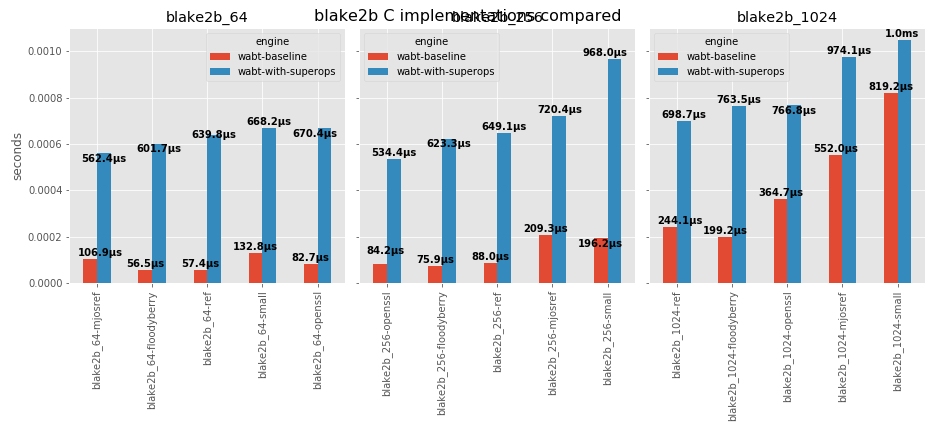

In [18]:
plotThreeTestsGrouped(df_scout_data, ["blake2b_64", "blake2b_256", "blake2b_1024"], "blake2b C implementations compared")


<Figure size 432x288 with 0 Axes>

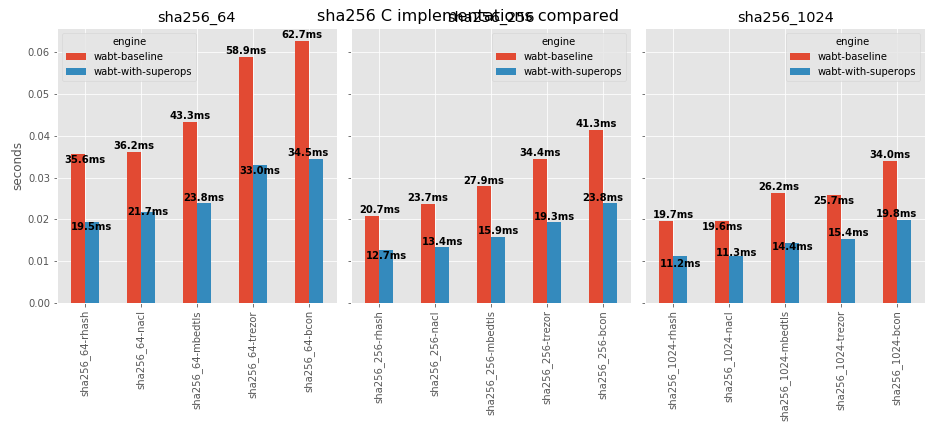

In [19]:
plotThreeTestsGrouped(df_scout_data, ["sha256_64", "sha256_256", "sha256_1024"], "sha256 C implementations compared")


<Figure size 432x288 with 0 Axes>

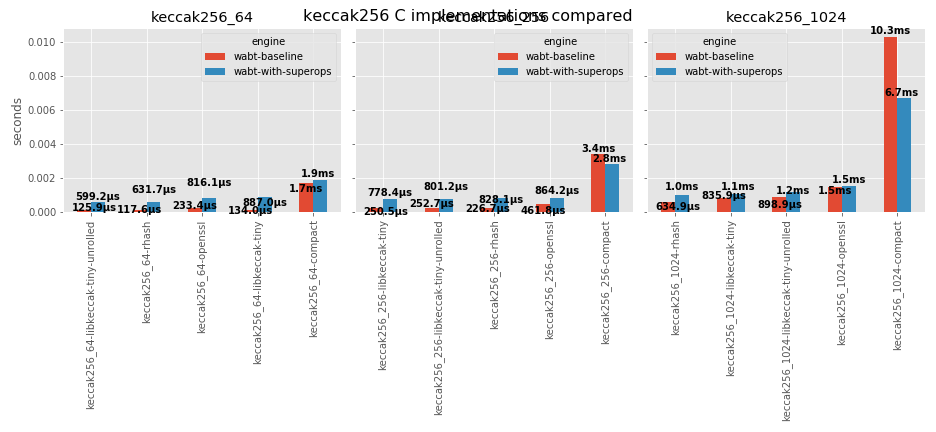

In [20]:
plotThreeTestsGrouped(df_scout_data, ["keccak256_64", "keccak256_256", "keccak256_1024"], "keccak256 C implementations compared")


## functions for plotting biturbo and bignum benchmarks

In [21]:
# non-stacked bar chart, for only plotting exec time or total time
def plotOneTest(df_data, suptitle="title", suptitle_pos=1.00, subtitle="subchart", subtitle_size='medium'):
    plt.figure()
    plt.tight_layout()
    df_total_times = df_data[['exec_time', 'parse_time']].copy()
    df_total_times.fillna(0, inplace=True)
    df_total_times['time'] = df_total_times['exec_time'] + df_total_times['parse_time']
    ax = df_total_times.sort_values('time')[['time']].plot.bar(figsize=(14,8), color=COLORS_DEFAULT['blue'])
    # fontsize = {size in points, 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
    ax.set_title(subtitle, fontsize=subtitle_size)
    ax.set(ylabel="seconds", xlabel="")
    ax.xaxis.set_tick_params(labelrotation=60, labelsize=12)
    adjust_text_labels(labelBarHeights(ax))
    plt.suptitle(suptitle, fontsize=18, y=suptitle_pos)
    plt.show()


In [22]:
# non-stacked bar chart, for only plotting exec time or total time
def plotOneTestColoredTicks(df_data, suptitle="title", suptitle_pos=1.00, subtitle="subchart", subtitle_size='medium', highlight_tick=None):
    plt.figure()
    plt.tight_layout()
    df_total_times = df_data[['exec_time', 'parse_time']].copy()
    df_total_times.fillna(0, inplace=True)
    df_total_times['time'] = df_total_times['exec_time'] + df_total_times['parse_time']
    ax = df_total_times.sort_values('time')[['time']].plot.bar(figsize=(14,8), color=COLORS_DEFAULT['blue'])
    # fontsize = {size in points, 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
    ax.set_title(subtitle, fontsize=subtitle_size)
    ax.set(ylabel="seconds", xlabel="")
    ax.xaxis.set_tick_params(labelrotation=60, labelsize=12)
    if highlight_tick is not None:
        for i in plt.gca().get_xticklabels():
            if i.get_text() == highlight_tick:
                i.set_color('tab:green')
                i.set_fontstyle('oblique')
                i.set_fontweight('heavy')
                
        # {'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'}
        #[i.set_color('tab:green') for i in plt.gca().get_xticklabels() if i.get_text() == highlight_tick]
    adjust_text_labels(labelBarHeights(ax))
    plt.suptitle(suptitle, fontsize=18, y=suptitle_pos)
    plt.show()

In [23]:
def plotOneTestGrouped(df_1, test_title="test_title", title="plot Title", colors=['tab:blue', 'tab:orange'], sort_by='websnark-bn128-two-pairings', group_order=None):
    # to group by engine, pivot to `columns='engine'`
    #df_1 = pd.pivot_table(df_1, values='exec_time', columns=['engine'], index=['bench_name'], aggfunc=np.mean)
    # group by bench name
    df_1['time'] = df_1['exec_time'] + df_1['parse_time']
    df_1 = pd.pivot_table(df_1, values='time', columns=['bench_name'], index=['engine'], aggfunc=np.mean)
    # order to get websnark as the group on the left
    if group_order is not None:
        df_1 = df_1[group_order]

    plt.figure()
    plt.tight_layout()
    ax = df_1.sort_values(sort_by).plot.bar(figsize=(14,8), color=colors)
    #ax = df_1.plot.bar(figsize=(14,8))
    ax.set_title(test_title)
    ax.set(ylabel='seconds', xlabel='')

    adjust_text_labels(labelBarHeights(ax))

    plt.suptitle(title, fontsize=16, y=0.98)
    plt.show()


In [24]:
def plotScoutStackedTest(df_data, suptitle="title", suptitle_pos=1.00, subtitle="subchart", subtitle_size='medium'):
    plt.figure()
    plt.tight_layout()
    # for some reason, exec_time needs to come first for the stacked chart to display correctly
    ax = df_data[['exec_time', 'parse_time']].sort_values('exec_time').plot.bar(stacked=True, color=[COLORS_DEFAULT['blue'], COLORS_DEFAULT['red']], figsize=(10,10))
    # fontsize = {size in points, 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
    ax.set_title(subtitle, fontsize=subtitle_size)
    ax.set(ylabel="seconds", xlabel="")
    df_total_times = df_data[['exec_time', 'parse_time']].copy()
    df_total_times['total_time'] = df_total_times['exec_time'] + df_total_times['parse_time']
    ax.xaxis.set_tick_params(labelrotation=60, labelsize=12)
    adjust_text_labels(labelBarHeights(ax, lower_y_bound=False))
    ax.legend(labels=["execution time", "startup time"])
    plt.suptitle(suptitle, fontsize=18, y=suptitle_pos)
    plt.show()


## Plot biturbo benchmark: biturbo-token-eth1-mainnet-stateless-block-hexary-trie-keccak256-multiproof

In [25]:
df_scout_biturbo_token = df_scout_data[df_scout_data['bench_name'] == 'biturbo-token-eth1-mainnet-stateless-block-hexary-trie-keccak256-multiproof']

df_scout_means_biturbo_token = df_scout_biturbo_token.groupby(['engine']).mean()
df_scout_fast_biturbo_token = filterDfEngines(df_scout_biturbo_token, ['v8-interpreter'])
df_scout_fast_biturbo_means = df_scout_fast_biturbo_token.groupby(['engine']).mean()



<Figure size 432x288 with 0 Axes>

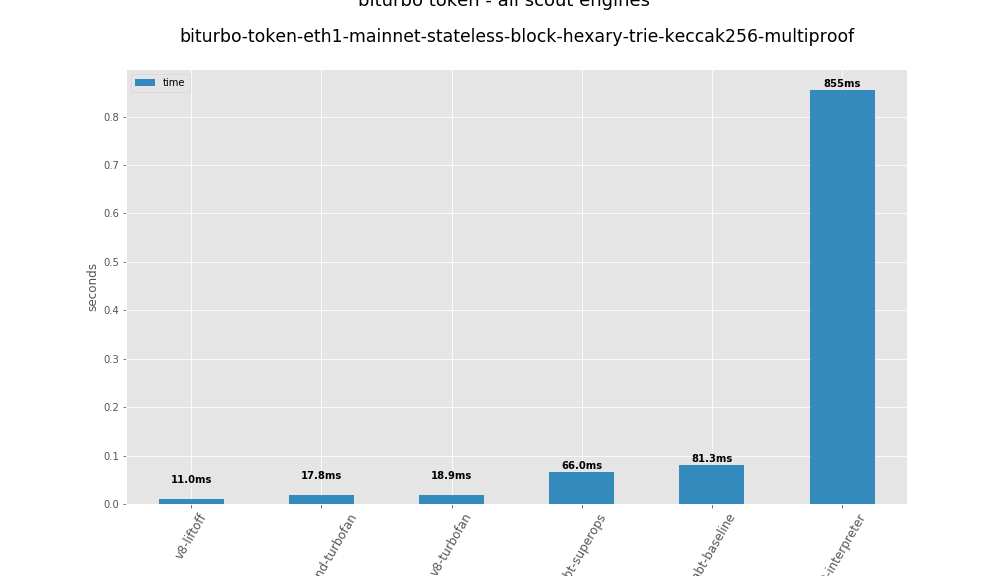

In [26]:
plotOneTest(df_scout_means_biturbo_token,
            suptitle="\nbiturbo token - all scout engines",
            suptitle_pos=1.05,
            subtitle="biturbo-token-eth1-mainnet-stateless-block-hexary-trie-keccak256-multiproof\n",
            subtitle_size='xx-large')

<Figure size 432x288 with 0 Axes>

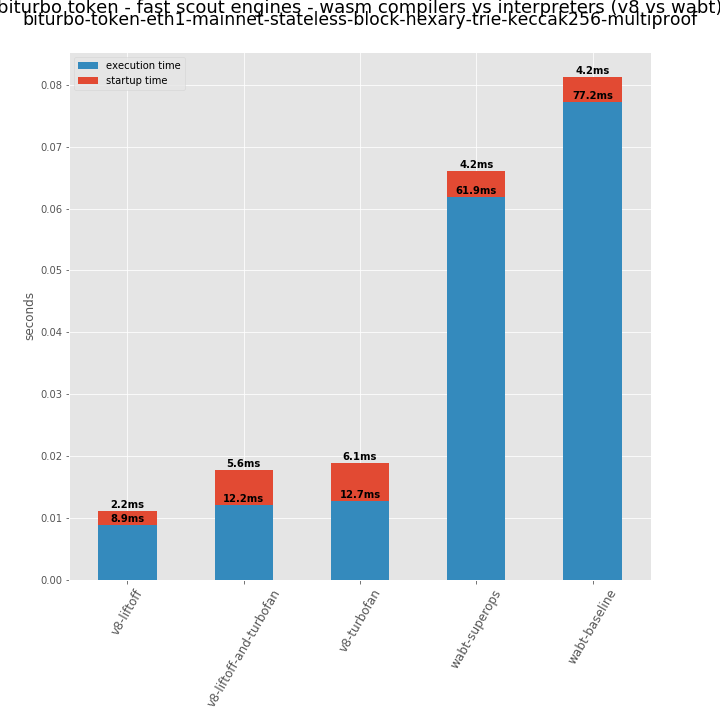

In [27]:
plotScoutStackedTest(df_scout_fast_biturbo_means,
            suptitle="\nbiturbo token - fast scout engines - wasm compilers vs interpreters (v8 vs wabt)",
            suptitle_pos=1.03,
            subtitle="biturbo-token-eth1-mainnet-stateless-block-hexary-trie-keccak256-multiproof\n",
            subtitle_size='xx-large')

## Plot bignum benchmark: ecrecover-eth1-txns-websnark-secp256k1-verify-72-sigs

In [28]:
df_scout_ecrecover_websnark_secp256k1 = df_scout_data[df_scout_data['bench_name'] == 'ecrecover-eth1-txns-websnark-secp256k1-verify-72-sigs']

df_scout_means_ecrecover_websnark_secp256k1 = df_scout_ecrecover_websnark_secp256k1.groupby(['engine']).mean()
df_scout_fast_ecrecover = filterDfEngines(df_scout_ecrecover_websnark_secp256k1,
    ['v8-interpreter', 'scoutcpp-wabt-no-bignums', 'wabt-no-bignums'])
df_scout_fast_ecrecover_means = df_scout_fast_ecrecover.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

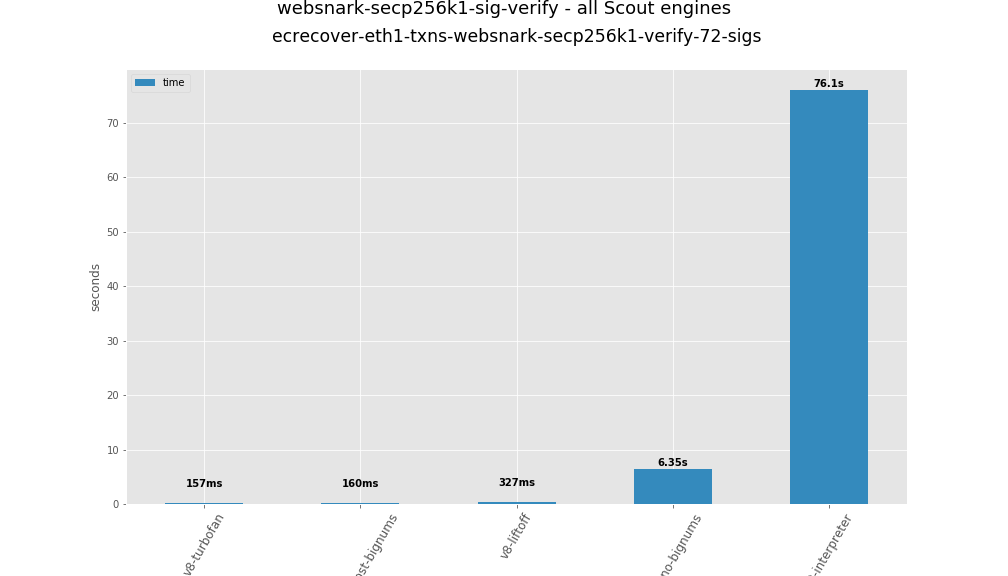

In [29]:
plotOneTest(df_scout_means_ecrecover_websnark_secp256k1,
            suptitle="websnark-secp256k1-sig-verify - all Scout engines",
            suptitle_pos=1.0,
            subtitle="ecrecover-eth1-txns-websnark-secp256k1-verify-72-sigs\n",
            subtitle_size='xx-large')

<Figure size 432x288 with 0 Axes>

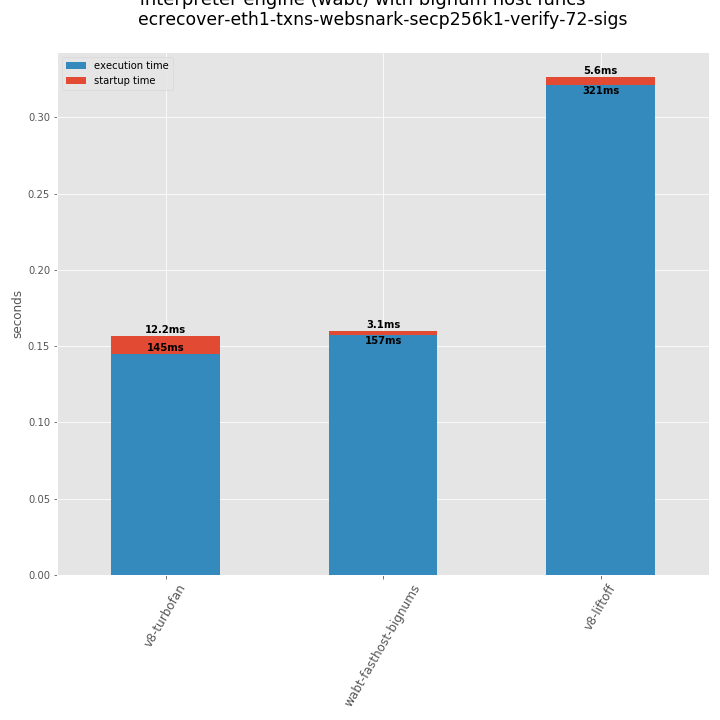

In [30]:
plotScoutStackedTest(df_scout_fast_ecrecover_means,
            #suptitle="websnark-secp256k1-sig-verify - fast Scout engines - compilers (v8) vs interpreters (wabt)",
            suptitle="compiler engines - optimizing (v8-turbofan) and single-pass (v8-liftoff) \n vs. \n interpreter engine (wabt) with bignum host funcs",
            suptitle_pos=1.07,
            subtitle="ecrecover-eth1-txns-websnark-secp256k1-verify-72-sigs\n",
            subtitle_size='xx-large')

## Plot bignum benchmark: ecpairing-zkrollup-websnark-bn128-two-pairings

In [31]:
df_scout_ecpairing_zkrollup_bn128_pairings = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-websnark-bn128-two-pairings']

df_scout_means_ecpairing_zkrollup = df_scout_ecpairing_zkrollup_bn128_pairings.groupby(['engine']).mean()
df_scout_fast_ecpairing_zkrollup = filterDfEngines(df_scout_ecpairing_zkrollup_bn128_pairings,
    ['v8-interpreter', 'scoutcpp-wabt-no-bignums', 'wabt-no-bignums'])
df_scout_fast_means_ecpairing_zkrollup = df_scout_fast_ecpairing_zkrollup.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

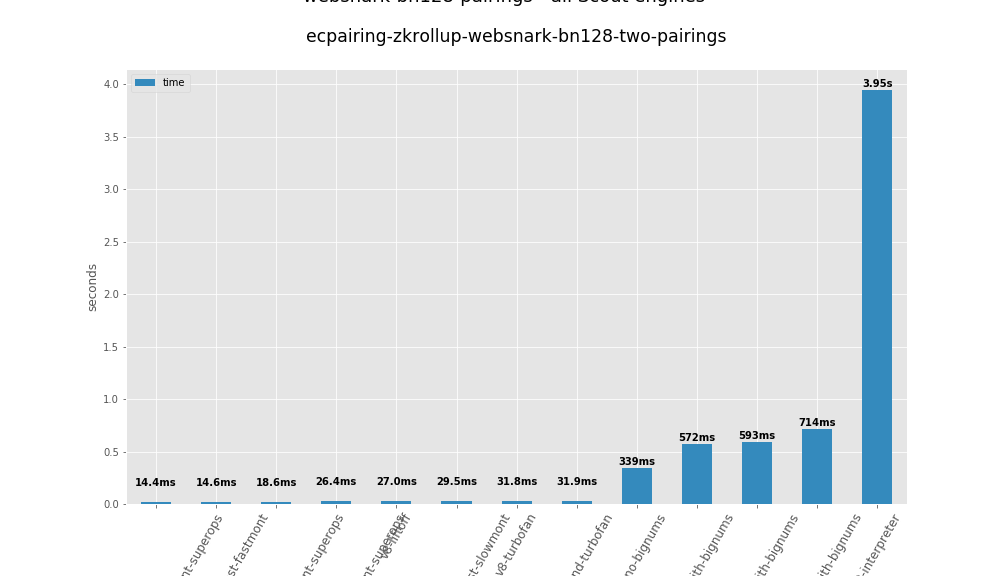

In [32]:
plotOneTest(df_scout_means_ecpairing_zkrollup,
            suptitle="websnark-bn128-pairings - all Scout engines",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-websnark-bn128-two-pairings\n",
            subtitle_size='xx-large')

<Figure size 432x288 with 0 Axes>

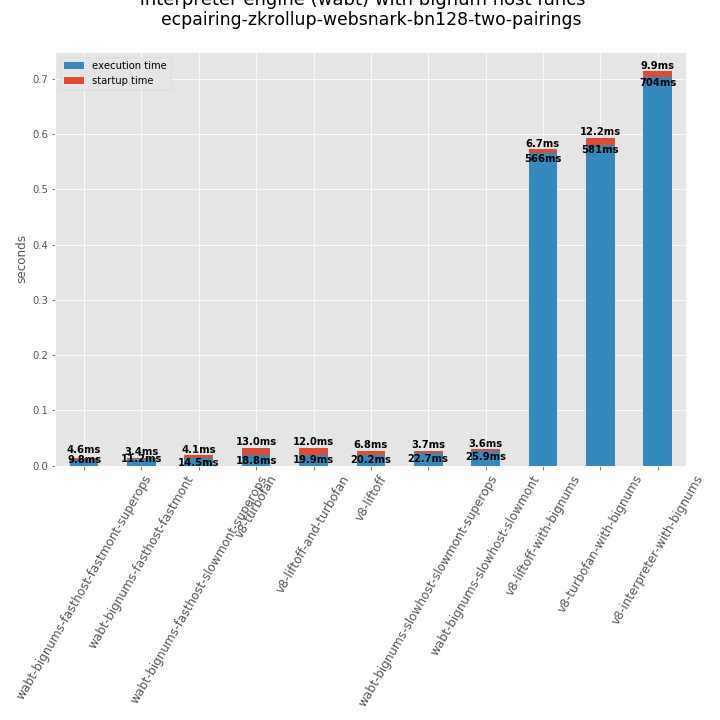

In [33]:
plotScoutStackedTest(df_scout_fast_means_ecpairing_zkrollup,
            suptitle="compiler engines - optimizing (v8-turbofan) and single-pass (v8-liftoff) \n vs. \n interpreter engine (wabt) with bignum host funcs",
            suptitle_pos=1.07,
            subtitle="ecpairing-zkrollup-websnark-bn128-two-pairings\n",
            subtitle_size='xx-large')

## start with rust bn128 pairings, compare to native, and compare interpreters to compilers

In [34]:
df_scout_rolluprs_bn128_pairings = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-rust-wasm-bn128-two-pairings']

df_scout_fast_rolluprs = filterDfEngines(df_scout_rolluprs_bn128_pairings,
    ['scoutcpp-wabt-no-bignums', 'wabt-no-bignums'])

df_scout_means_rolluprs = df_scout_rolluprs_bn128_pairings.groupby(['engine']).mean()

#df_scout_fast_means_rolluprs = df_scout_fast_rolluprs.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

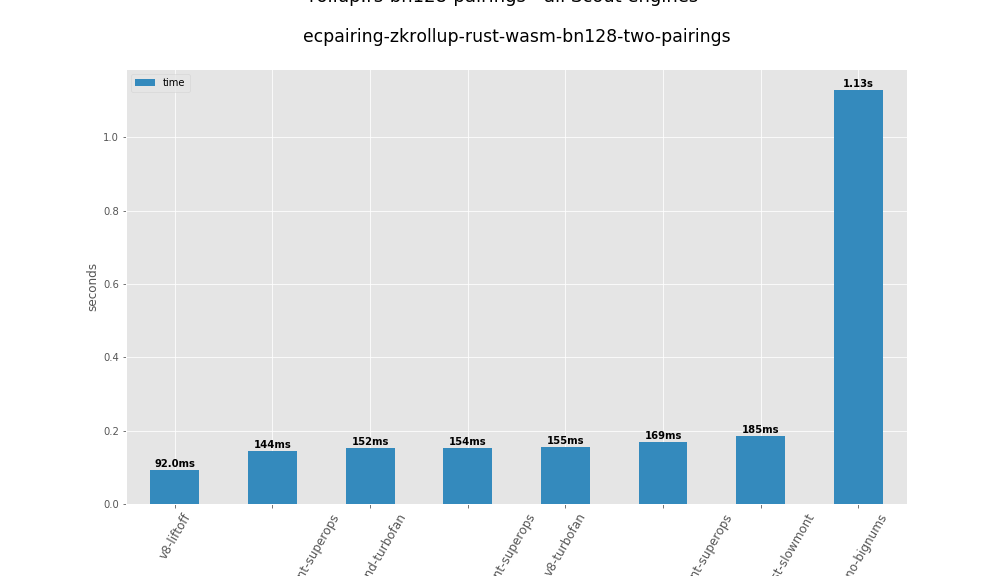

In [35]:
plotOneTest(df_scout_means_rolluprs,
            suptitle="rollup.rs-bn128-pairings - all Scout engines",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-rust-wasm-bn128-two-pairings\n",
            subtitle_size='xx-large')


## websnark bn128 pairings versus rust->wasm bn128 pairings

### add rust-native to rust-wasm

In [36]:
df_scout_rolluprs_bn128_pairings = df_scout_data[df_scout_data['bench_name'].isin(
    ['ecpairing-zkrollup-rust-wasm-bn128-two-pairings', 'ecpairing-zkrollup-rust-native-bn128-two-pairings']
)]

#df_scout_rolluprs_rustnative = df_scout_rolluprs_rustnative.fillna(0)

df_scout_means_rolluprs = df_scout_rolluprs_bn128_pairings.groupby(['engine']).mean()
df_scout_fast_rolluprs = filterDfEngines(df_scout_rolluprs_bn128_pairings,
    ['v8-interpreter', 'scoutcpp-wabt-no-bignums', 'wabt-no-bignums'])
df_scout_fast_means_rolluprs = df_scout_fast_rolluprs.groupby(['engine']).mean()

<Figure size 432x288 with 0 Axes>

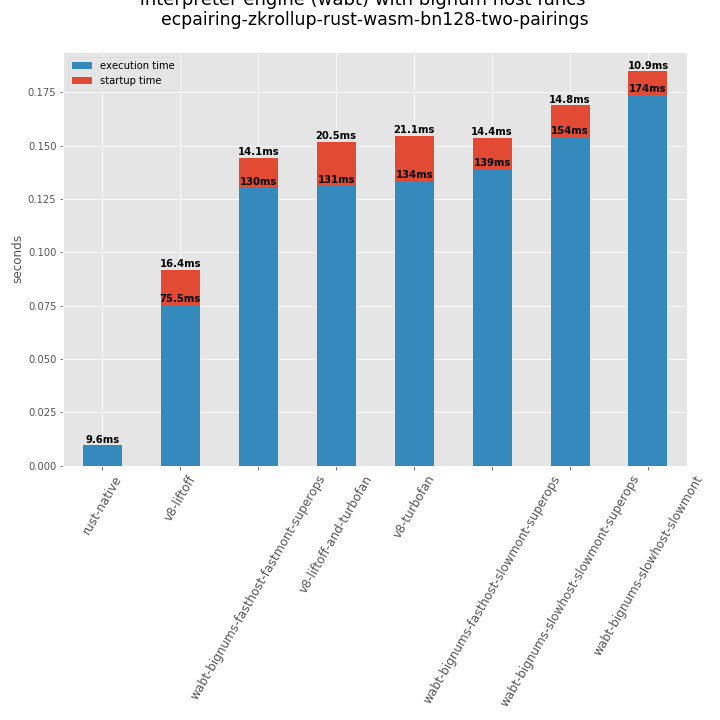

In [37]:
plotScoutStackedTest(df_scout_fast_means_rolluprs,
            suptitle="compiler engines - optimizing (v8-turbofan) and single-pass (v8-liftoff) \n vs. \n interpreter engine (wabt) with bignum host funcs",
            suptitle_pos=1.07,
            subtitle="ecpairing-zkrollup-rust-wasm-bn128-two-pairings\n",
            subtitle_size='xx-large')

# rust vs websnark

In [139]:
df_scout_rust_vs_websnark = df_scout_data[
    df_scout_data['bench_name'].isin(
        ['ecpairing-zkrollup-rust-wasm-bn128-two-pairings',
         'ecpairing-zkrollup-websnark-bn128-two-pairings']
    )
].copy()


In [140]:
#df_scout_rust_vs_websnark

In [141]:
#df_scout_rust_vs_websnark.replace('ecpairing-zkrollup-rust-wasm-bn128-two-pairings', 'rust-wasm-bn128-two-pairings', inplace=True)
#df_scout_rust_vs_websnark.replace('ecpairing-zkrollup-websnark-bn128-two-pairings', 'websnark-bn128-two-pairings', inplace=True)

df_scout_rust_vs_websnark.replace('ecpairing-zkrollup-rust-wasm-bn128-two-pairings', 'rust-wasm', inplace=True)
df_scout_rust_vs_websnark.replace('ecpairing-zkrollup-websnark-bn128-two-pairings', 'websnark-wasm', inplace=True)




In [142]:
df_scout_rust_vs_websnark = df_scout_rust_vs_websnark[df_scout_rust_vs_websnark['engine'].isin(
['wabt-superops-bignums-slowmont', 'wabt-bignums-fasthost', 'wabt-superops-bignums', 'rust-native', 'v8-liftoff', 'v8-turbofan']  
)].copy()

In [143]:
df_scout_rust_vs_websnark

,engine,bench_name,parse_time,exec_time
1383,v8-turbofan,websnark-wasm,0.012526,0.019856
1384,v8-liftoff,websnark-wasm,0.006579,0.019689
1390,v8-turbofan,rust-wasm,0.020768,0.117253
1391,v8-liftoff,rust-wasm,0.014276,0.070435
1404,v8-turbofan,websnark-wasm,0.009650,0.021088
1405,v8-liftoff,websnark-wasm,0.008004,0.024127
1411,v8-turbofan,rust-wasm,0.026583,0.149700
1412,v8-liftoff,rust-wasm,0.014841,0.073529
1425,v8-turbofan,websnark-wasm,0.012767,0.022378
1426,v8-liftoff,websnark-wasm,0.005548,0.019110


In [43]:
# {'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'}


<Figure size 432x288 with 0 Axes>

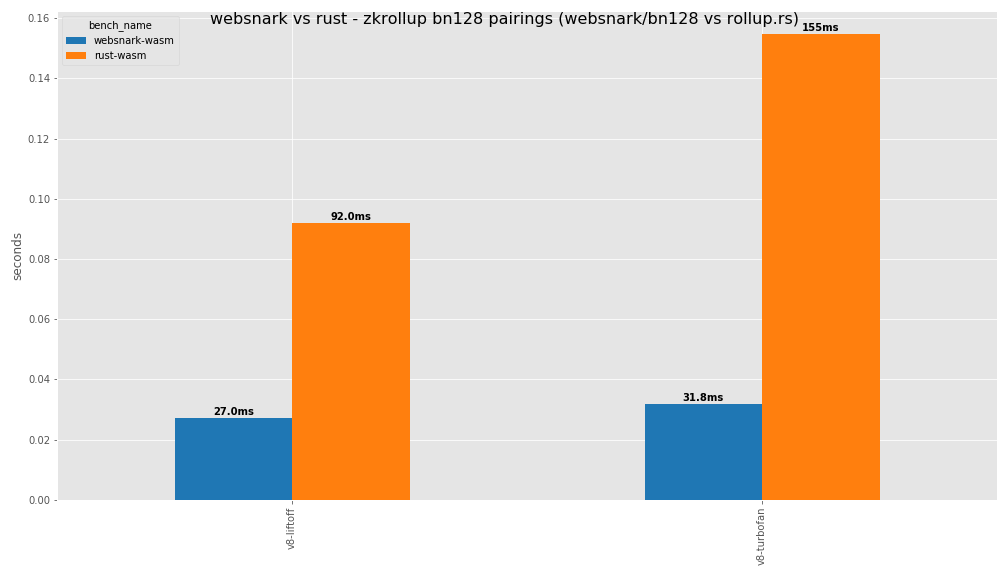

In [44]:
plotOneTestGrouped(df_scout_rust_vs_websnark,
                   title="websnark vs rust - zkrollup bn128 pairings (websnark/bn128 vs rollup.rs)",
                   test_title="",
                   group_order=['websnark-wasm', 'rust-wasm'],
                   sort_by="rust-wasm",
                   colors=['tab:blue', 'tab:orange'])

In [45]:
df_rolluprs_native = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-rust-native-bn128-two-pairings']
df_rolluprs_native = df_rolluprs_native.fillna(0)

df_rolluprs_native.replace('ecpairing-zkrollup-rust-native-bn128-two-pairings', 'rust-native', inplace=True)


df_scout_rust_vs_websnark_fast_vs_native = df_scout_rust_vs_websnark.append(df_rolluprs_native, sort=False)

<Figure size 432x288 with 0 Axes>

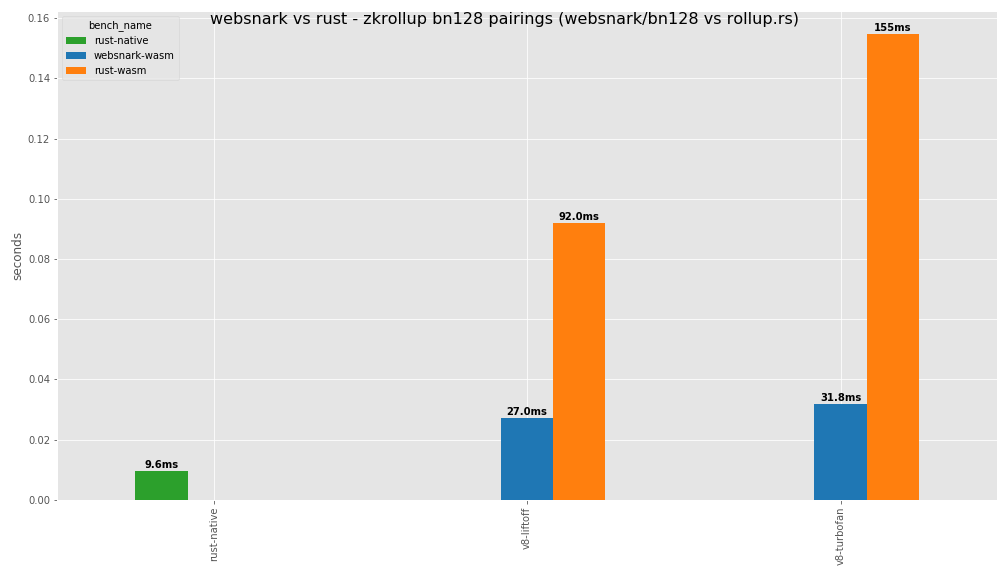

In [46]:

plotOneTestGrouped(df_scout_rust_vs_websnark_fast_vs_native,
               title="websnark vs rust - zkrollup bn128 pairings (websnark/bn128 vs rollup.rs)",
               test_title="",
               sort_by=["rust-native", "rust-wasm", "websnark-wasm"],
               colors=['tab:green', 'tab:blue', 'tab:orange'],
               group_order=["rust-native", "websnark-wasm", "rust-wasm"])


## Just websnark against native

In [47]:
# print out the engine names

df_websnark_vs_native = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-websnark-bn128-two-pairings'].copy()
df_websnark_vs_native.replace('ecpairing-zkrollup-websnark-bn128-two-pairings', 'websnark-bn128-two-pairings', inplace=True)

df_websnark_vs_native['engine'].unique().tolist()

['wabt-no-bignums',
 'wabt-bignums-slowhost-slowmont',
 'wabt-bignums-slowhost-slowmont-superops',
 'wabt-bignums-fasthost-slowmont-superops',
 'wabt-bignums-fasthost-fastmont-superops',
 'wabt-bignums-fasthost-fastmont',
 'v8-turbofan',
 'v8-liftoff',
 'v8-liftoff-and-turbofan',
 'v8-interpreter',
 'v8-turbofan-with-bignums',
 'v8-liftoff-with-bignums',
 'v8-interpreter-with-bignums']

In [48]:
df_websnark_vs_native = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-websnark-bn128-two-pairings'].copy()
df_websnark_vs_native.replace('ecpairing-zkrollup-websnark-bn128-two-pairings', 'websnark-bn128-two-pairings', inplace=True)

df_websnark_vs_native = df_websnark_vs_native[df_websnark_vs_native['engine'].isin(
['wabt-bignums-fasthost', 'wabt-bignums-slowhost', 'wabt-superops-bignums', 'wabt-superops-bignums-slowmont', 'wabt-with-bignums-and-superops', 'wabt-with-bignums', 'rust-native', 'v8-liftoff', 'v8-turbofan']  
)]

df_websnark_vs_native = df_websnark_vs_native.append(df_rolluprs_native)

df_websnark_vs_native_means = df_websnark_vs_native.groupby(['engine']).mean()


In [49]:
#df_websnark_vs_native_means

<Figure size 432x288 with 0 Axes>

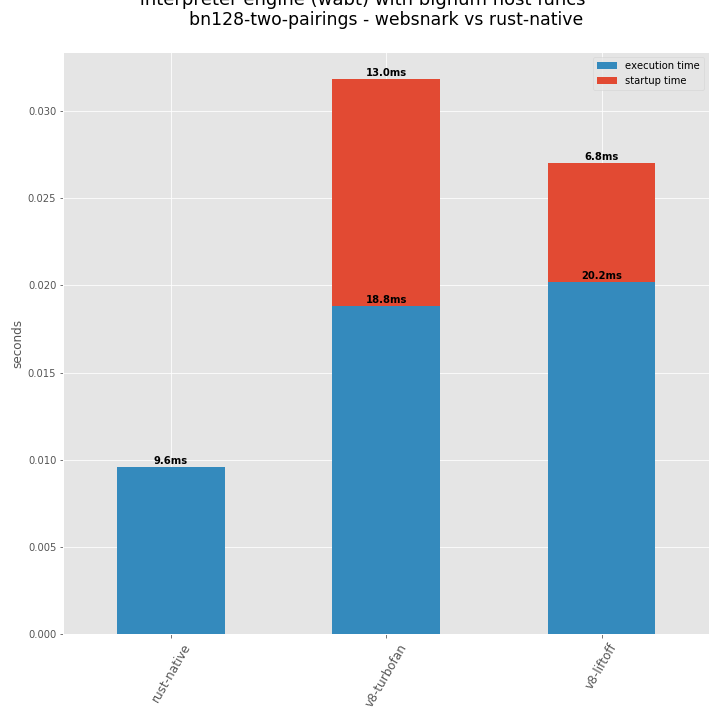

In [50]:
plotScoutStackedTest(df_websnark_vs_native_means,
            suptitle="compiler engines - optimizing (v8-turbofan) and single-pass (v8-liftoff) \n vs. \n interpreter engine (wabt) with bignum host funcs",
            suptitle_pos=1.07,
            subtitle="bn128-two-pairings - websnark vs rust-native\n",
            subtitle_size='xx-large')

# Try Seaborn with error bars

In [51]:
import seaborn as sns

In [52]:
df_websnark_vs_native['time'] = df_websnark_vs_native['exec_time'] + df_websnark_vs_native['parse_time']


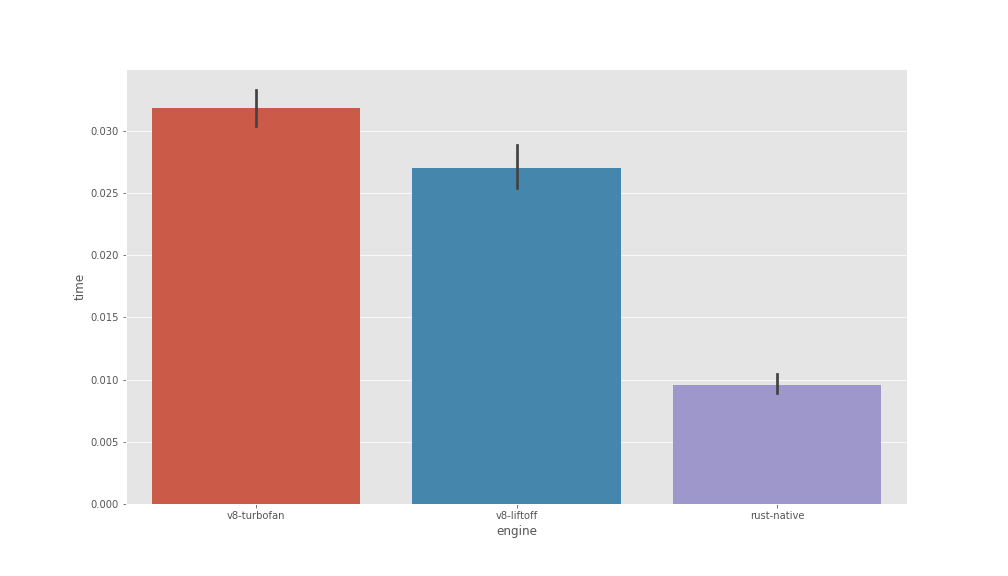

In [53]:
f = plt.figure(figsize=(14,8))

sns.barplot(x='engine', y='time', data=df_websnark_vs_native)

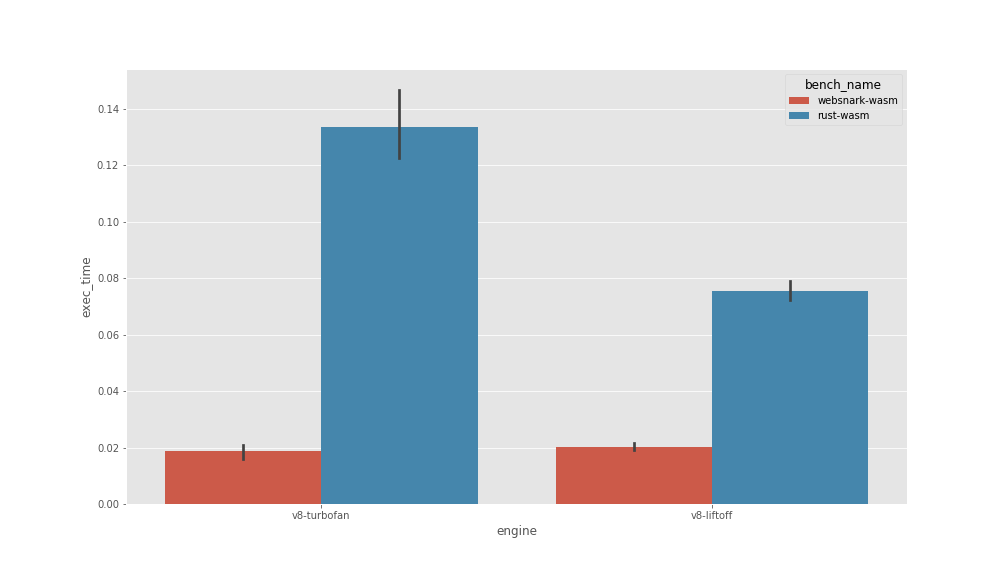

In [54]:
f = plt.figure(figsize=(14,8))

sns.barplot(x='engine', y='exec_time', hue='bench_name', data=df_scout_rust_vs_websnark)

## Plot bignum benchmark: daiquiri-zkmixer-websnark-bn128-groth16-four-pairings-and-mimc

In [55]:
df_scout_daiquiri_zkmixer = df_scout_data[df_scout_data['bench_name'] == 'daiquiri-zkmixer-websnark-bn128-groth16-four-pairings-and-mimc']

df_scout_means_daiquiri_zkmixer = df_scout_daiquiri_zkmixer.groupby(['engine']).mean()
df_scout_fast_daiquiri_zkmixer = filterDfEngines(df_scout_daiquiri_zkmixer,
    ['v8-interpreter', 'scoutcpp-wabt-no-bignums', 'wabt-no-bignums'])
df_scout_fast_means_daiquiri_zkmixer = df_scout_fast_daiquiri_zkmixer.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

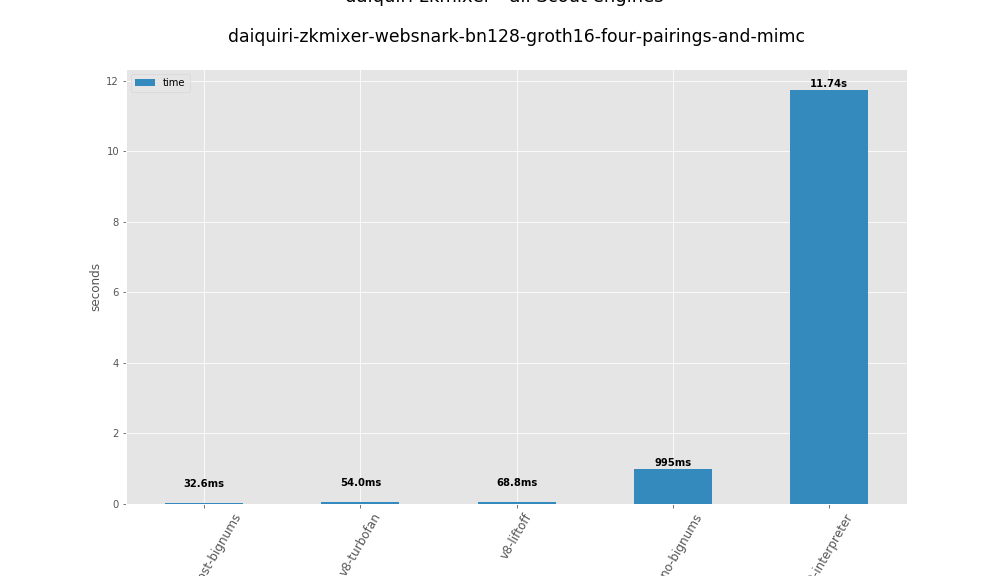

In [56]:
plotOneTest(df_scout_means_daiquiri_zkmixer,
            suptitle="daiquiri-zkmixer - all Scout engines",
            suptitle_pos=1.02,
            subtitle="daiquiri-zkmixer-websnark-bn128-groth16-four-pairings-and-mimc\n",
            subtitle_size='xx-large')

<Figure size 432x288 with 0 Axes>

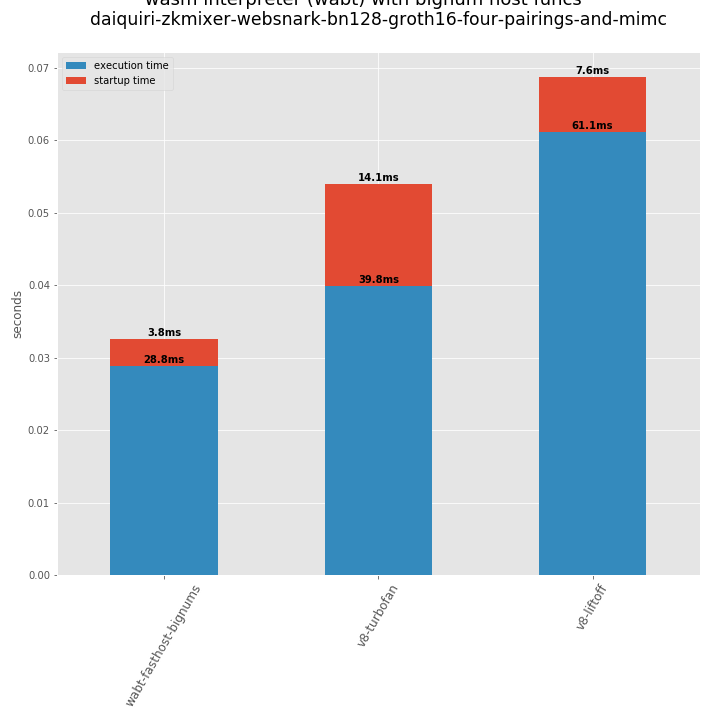

In [57]:
plotScoutStackedTest(df_scout_fast_means_daiquiri_zkmixer,
            suptitle="wasm compilers - optimizing (v8-turbofan) and single-pass (v8-liftoff) \n vs. \n wasm interpreter (wabt) with bignum host funcs",
            suptitle_pos=1.07,
            subtitle="daiquiri-zkmixer-websnark-bn128-groth16-four-pairings-and-mimc\n",
            subtitle_size='xx-large')

## Import geth precompile results

In [58]:
df_geth_precompiles = read_results(join(CSV_RESULT_DIR, GETH_PRECOMPILE_RESULT_FILE))

In [59]:
#df_geth_precompiles

In [60]:
def splitName(test_name):
    ix = test_name.find("/")
    return (test_name[0:ix], test_name[ix+1:])


In [61]:
df_geth_precompiles['precompile_name'], df_geth_precompiles['input_name'] = zip(*df_geth_precompiles.apply(lambda row: splitName(row['test_name']), axis=1))


In [62]:
df_geth_precompiles = df_geth_precompiles[['precompile_name', 'input_name', 'gas', 'time']]

In [63]:
df_geth_native_bn128pairing = df_geth_precompiles[df_geth_precompiles["input_name"] == "two_point_match_rollup_input"].copy()


In [64]:
df_geth_native_bn128pairing

,precompile_name,input_name,gas,time
57,PrecompiledBn256Pairing,two_point_match_rollup_input,113000,0.004205


### Import standalone wasm results

In [65]:
df_wasm = read_results(join(CSV_RESULT_DIR, STANDALONE_WASM_RESULT_FILE))

In [66]:
df_wasm

,engine,test_name,elapsed_time,compile_time,exec_time
0,wagon,ecpairing,11.071656,0.294048,10.590186
1,wagon,ecpairing,10.858861,0.242949,10.612869
2,wagon,ecpairing,10.845982,0.242416,10.600568
3,wagon,ecpairing,10.857219,0.245097,10.609369
4,wagon,ecpairing,10.858783,0.244124,10.611678
...,...,...,...,...,...
16364,fizzy,blake2b-8415-bytes,2.805884,0.000032,0.001740
16365,fizzy,blake2b-8415-bytes,2.785907,0.000029,0.001740
16366,fizzy,blake2b-8415-bytes,2.760013,0.000030,0.001746
16367,fizzy,blake2b-8415-bytes,2.786925,0.000030,0.001754


### Import native results

In [67]:
df_native_raw = read_results(join(CSV_RESULT_DIR, NATIVE_RESULT_FILE))

In [68]:
native_results = {}
for i in range(len(df_native_raw)):
    test_name = df_native_raw['test_name'][i]
    native_results[test_name] = df_native_raw['elapsed_times'][i].split(', ')

    
test_names = df_native_raw['test_name'].tolist()

native_times = {}
for test in test_names:
    avg = np.mean([float(t) for t in native_results[test]])
    native_times[test] = avg

    
df_native = pd.DataFrame.from_dict(native_times, orient='index', columns=['elapsed_time'])
df_native['engine'] = 'rust-native'

In [69]:
df_native

,elapsed_time,engine
blake2b-8415-bytes,0.000026,rust-native
blake2b-5610-bytes,0.000012,rust-native
blake2b-2805-bytes,0.000008,rust-native
bls12-381-aggreg-128-pubkeys-verify-sig,0.027138,rust-native
bls12-381-aggreg-64-pubkeys-verify-sig,0.028107,rust-native
bls12-381-aggreg-32-pubkeys-verify-sig,0.024123,rust-native
bn128_pairing-ten_point_match_1,0.021701,rust-native
bn128_pairing-one_point,0.006033,rust-native
bn128_pairing-two_point_match_2,0.010407,rust-native
sha1-10808-bits,0.000007,rust-native


### sorted lists of test names for plotting inputs in order

In [70]:
blake2b_test_names = [name for name in df_wasm['test_name'].unique().tolist() if 'blake2b' in name]
blake2b_test_names.sort()
blake2b_test_names_desc = blake2b_test_names.copy()
blake2b_test_names_desc.reverse()


In [71]:
sha1_test_names = [name for name in df_wasm['test_name'].unique().tolist() if 'sha1' in name]
sha1_test_names.sort()
sha1_test_names_desc = sha1_test_names.copy()
sha1_test_names_desc.reverse()


In [72]:

bn128_mul_test_names = ['bn128_mul-cdetrio11', 'bn128_mul-chfast2', 'bn128_mul-chfast1']
bn128_add_test_names = ['bn128_add-cdetrio11', 'bn128_add-cdetrio14', 'bn128_add-cdetrio10']
bn128_pairing_test_names = ['bn128_pairing-ten_point_match_1', 'bn128_pairing-two_point_match_2', 'bn128_pairing-one_point']

bn128_mul_test_names.reverse()
bn128_add_test_names.reverse()
bn128_pairing_test_names.reverse()

bn128_mul_test_names_desc = ['bn128_mul-cdetrio11', 'bn128_mul-chfast2', 'bn128_mul-chfast1']
bn128_add_test_names_desc = ['bn128_add-cdetrio11', 'bn128_add-cdetrio14', 'bn128_add-cdetrio10']
bn128_pairing_test_names_desc = ['bn128_pairing-ten_point_match_1', 'bn128_pairing-two_point_match_2', 'bn128_pairing-one_point']



In [73]:
bls12_test_names = ['bls12-381-aggreg-32-pubkeys-verify-sig', 'bls12-381-aggreg-64-pubkeys-verify-sig', 'bls12-381-aggreg-128-pubkeys-verify-sig']
bls12_test_names_desc = bls12_test_names.copy()
bls12_test_names_desc.reverse()

In [74]:
modexp_test_names = [name for name in df_wasm['test_name'].unique().tolist() if 'modexp' in name]
modexp_test_names.sort()
modexp_test_names_desc = modexp_test_names.copy()
modexp_test_names_desc.reverse()

In [75]:
all_tests = sha1_test_names + blake2b_test_names + modexp_test_names + ['ed25519-verify-ten-inputs'] + bls12_test_names \
    + bn128_add_test_names + bn128_mul_test_names + bn128_pairing_test_names

### Prepare interpreter dataframe

In [76]:
all_interp_test_names = []

interp_results_for_df = []
for engine in INTERPRETER_ENGINES:
    df_engine = df_wasm[df_wasm['engine'] == engine]
    df_means = df_engine.groupby(['test_name']).mean()
    test_names = df_engine['test_name'].unique().tolist()
    all_interp_test_names.extend(test_names)
    for test_name in test_names:
        interp_results_for_df.append([engine, test_name] + df_means.loc[test_name].tolist())

        
all_interp_test_names = set(all_interp_test_names)

#interp_results_for_df

df_interp = pd.DataFrame(interp_results_for_df)
df_interp.columns = ['engine', 'test_name', 'elapsed_time', 'parse_time', 'exec_time']
df_interp.set_index('engine', inplace=True)
df_interp['total_time'] = df_interp['parse_time'] + df_interp['exec_time']
#df_interp

In [77]:
df_wasm['test_name'].unique().tolist()

['ecpairing',
 'sha1-21896-bits',
 'bn128_mul-chfast1',
 'bn128_mul-cdetrio11',
 'bn128_add-cdetrio10',
 'blake2b-2805-bytes',
 'bn128_mul-cdetrio7',
 'bn128_mul-cdetrio12',
 'bn128_mul-chfast3',
 'sha1-42488-bits',
 'blake2b-5610-bytes',
 'bls12-381-aggreg-64-pubkeys-verify-sig',
 'modexp-eip_example1',
 'modexp-nagydani-1-square',
 'bls12-381-aggreg-32-pubkeys-verify-sig',
 'bn128_pairing-ten_point_match_1',
 'ed25519-verify-ten-inputs',
 'bn128_mul-cdetrio2',
 'bn128_mul-cdetrio6',
 'blake2b-8415-bytes',
 'bls12-381-aggreg-128-pubkeys-verify-sig',
 'bn128_pairing-two_point_match_2',
 'bn128_mul-chfast2',
 'bn128_pairing-one_point',
 'bn128_add-cdetrio14',
 'bn128_add-cdetrio11',
 'sha1-10808-bits',
 'modexp-nagydani-1-qube',
 'guido-fuzzer-find-1',
 'guido-fuzzer-find-2-norotates',
 'guido-fuzzer-find-2']

## Interpreter engines compared

In [78]:
def plotInterpThreeTests(df_testdata, three_names, title="Title", filter_engines=None):
    if filter_engines is not None:
        df_testdata = filterDfEngines(df_testdata.reset_index(), filter_engines)
        df_testdata.set_index('engine', inplace=True)
    df_1 = df_testdata[df_testdata['test_name'] == three_names[0]]
    df_2 = df_testdata[df_testdata['test_name'] == three_names[1]]
    df_3 = df_testdata[df_testdata['test_name'] == three_names[2]]
    plt.figure()
    f, (ax1) = plt.subplots(1, 3, sharey=True, figsize=(16,7))
    df_1.sort_values('total_time')[['parse_time', 'exec_time']].plot.bar(ax=ax1[0], stacked=True)
    ax1[0].set_title(three_names[0])
    ax1[0].set(xlabel='')
    df_2.sort_values('total_time')[['parse_time', 'exec_time']].plot.bar(ax=ax1[1], stacked=True)
    ax1[1].set_title(three_names[1])
    ax1[1].set(xlabel='')
    df_3.sort_values('total_time')[['parse_time', 'exec_time']].plot.bar(ax=ax1[2], stacked=True)
    ax1[2].set_title(three_names[2])
    ax1[2].set(xlabel='')
    adjust_text_labels(labelBarHeights(ax1[0]), ax=ax1[0])
    adjust_text_labels(labelBarHeights(ax1[1]), ax=ax1[1])
    adjust_text_labels(labelBarHeights(ax1[2]), ax=ax1[2])
    ax1[0].legend(labels=["startup time", "execution time"])
    ax1[1].legend(labels=["startup time", "execution time"])
    ax1[2].legend(labels=["startup time", "execution time"])

    ax1[1].tick_params(axis='y', left=True, labelleft=True)
    ax1[2].tick_params(axis='y', left=True, labelleft=True)
    
    scale_y = 1e-3
    ticks_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/scale_y))
    ax1[1].yaxis.set_major_formatter(ticks_y)
    
    ax1[0].set(ylabel='milliseconds')
    
    f.suptitle(title, fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

<Figure size 432x288 with 0 Axes>

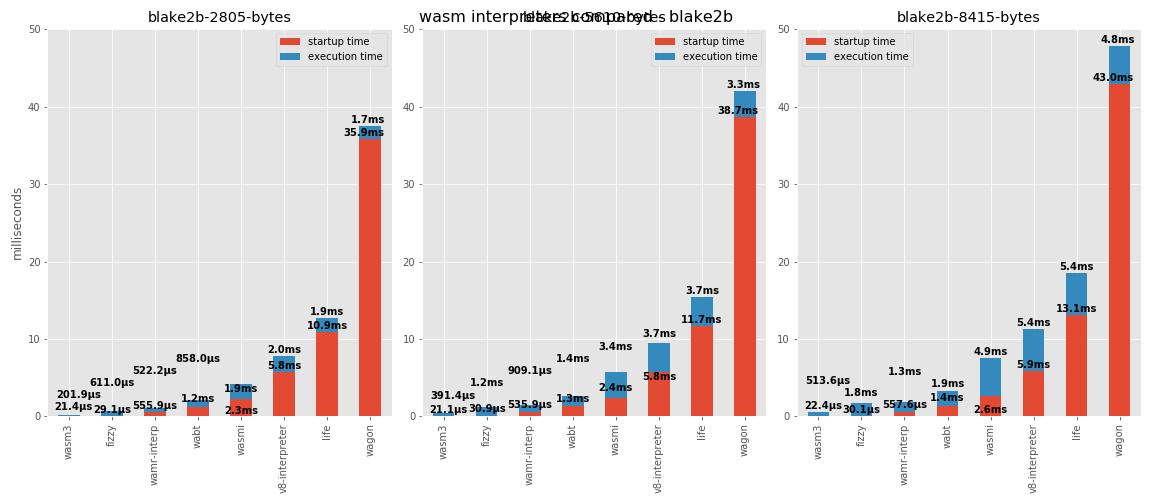

In [79]:
plotInterpThreeTests(df_interp, blake2b_test_names, title="wasm interpreters compared - blake2b")

### Interpreters - Execution time

In [80]:
def plotThreeTestsExecTime(df_testdata, three_names, title="Title", filter_engines=None):
    if filter_engines is not None:
        df_testdata = filterDfEngines(df_testdata.reset_index(), filter_engines)
        df_testdata.set_index('engine', inplace=True)
    df_1 = df_testdata[df_testdata['test_name'] == three_names[0]]
    df_2 = df_testdata[df_testdata['test_name'] == three_names[1]]
    df_3 = df_testdata[df_testdata['test_name'] == three_names[2]]
    plt.figure()
    f, (ax1) = plt.subplots(1, 3, sharey=True, figsize=(16,7))
    df_1.sort_values('exec_time')[['exec_time']].plot.bar(ax=ax1[0], color=COLORS_DEFAULT['blue'])
    ax1[0].set_title(three_names[0])
    ax1[0].set(xlabel='')
    df_2.sort_values('exec_time')[['exec_time']].plot.bar(ax=ax1[1], color=COLORS_DEFAULT['blue'])
    ax1[1].set_title(three_names[1])
    ax1[1].set(xlabel='')
    df_3.sort_values('exec_time')[['exec_time']].plot.bar(ax=ax1[2], color=COLORS_DEFAULT['blue'])
    ax1[2].set_title(three_names[2])
    ax1[2].set(xlabel='')
    adjust_text_labels(labelBarHeights(ax1[0]), ax=ax1[0])
    adjust_text_labels(labelBarHeights(ax1[1]), ax=ax1[1])
    adjust_text_labels(labelBarHeights(ax1[2]), ax=ax1[2])
    ax1[0].legend(labels=["execution time"])
    ax1[1].legend(labels=["execution time"])
    ax1[2].legend(labels=["execution time"])

    ax1[1].tick_params(axis='y', left=True, labelleft=True)
    ax1[2].tick_params(axis='y', left=True, labelleft=True)
   
    scale_y = 1e-3
    ticks_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/scale_y))
    ax1[1].yaxis.set_major_formatter(ticks_y)
    
    ax1[0].set(ylabel='milliseconds')
    
    f.suptitle(title, fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()


<Figure size 432x288 with 0 Axes>

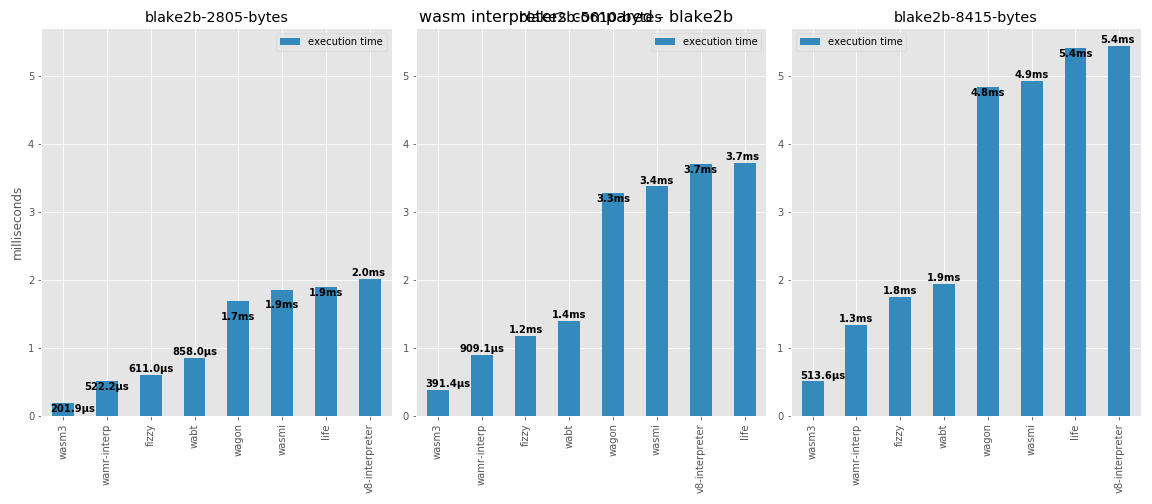

In [81]:
plotThreeTestsExecTime(df_interp, blake2b_test_names, title="wasm interpreters compared - blake2b")

## Chart of only the fast interpreters

<Figure size 432x288 with 0 Axes>

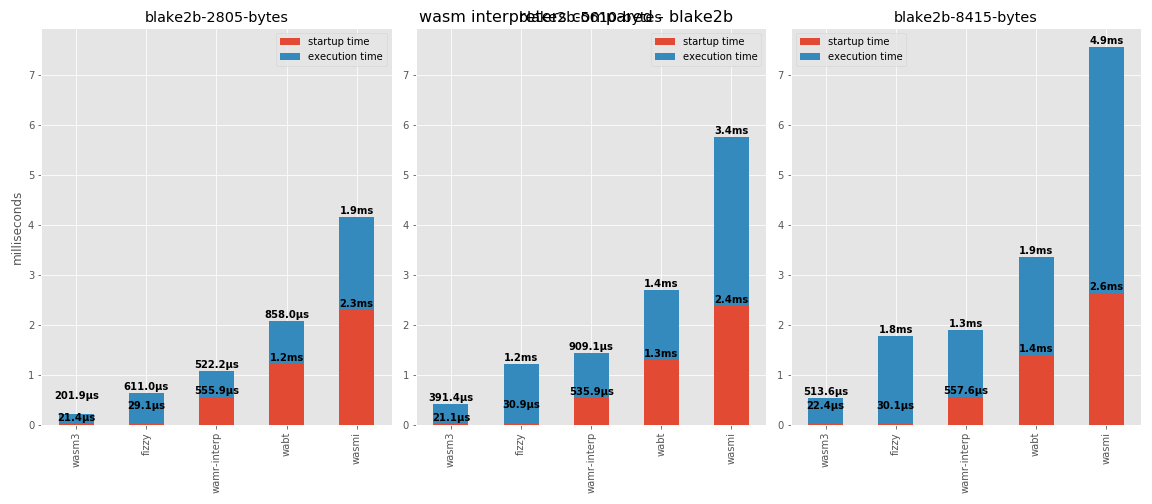

In [82]:
plotInterpThreeTests(df_interp,
                     blake2b_test_names,
                     title="wasm interpreters compared - blake2b",
                     filter_engines=["life", "wagon", "v8-interpreter"])

<Figure size 432x288 with 0 Axes>

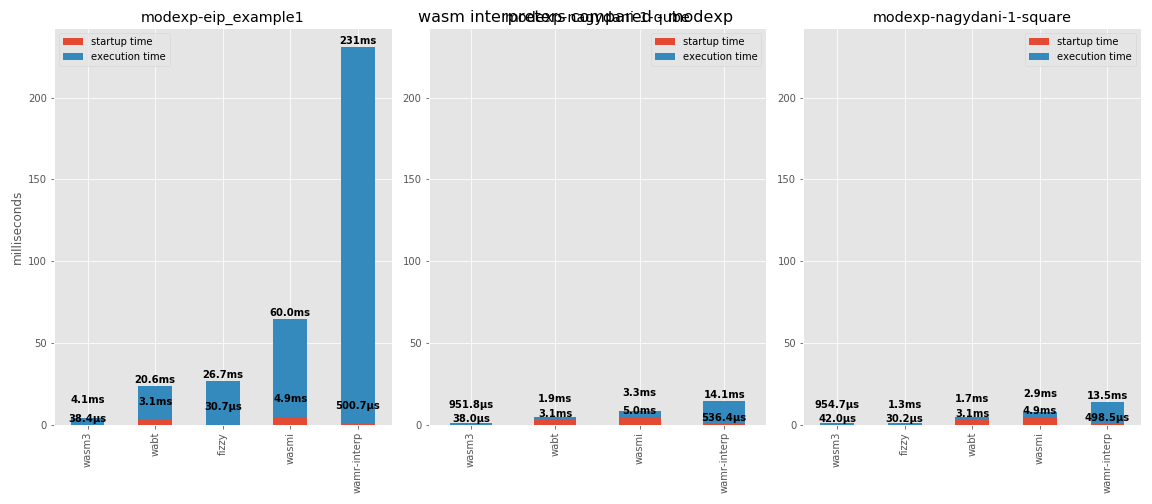

In [83]:
plotInterpThreeTests(df_interp,
                     modexp_test_names,
                     title="wasm interpreters compared - modexp",
                     filter_engines=["life", "wagon", "v8-interpreter"])

<Figure size 432x288 with 0 Axes>

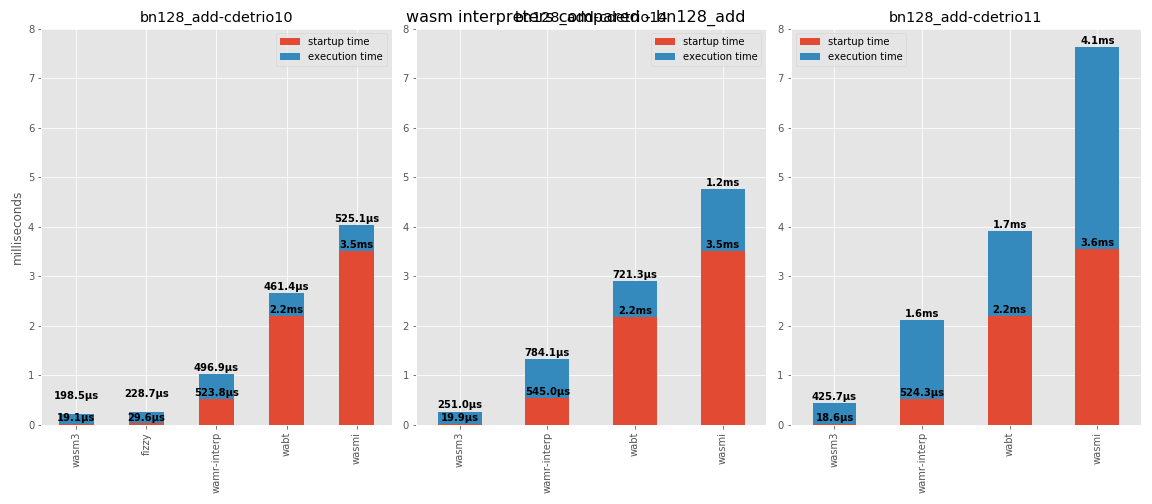

In [84]:
plotInterpThreeTests(df_interp,
                     bn128_add_test_names,
                     title="wasm interpreters compared - bn128_add",
                     filter_engines=["life", "wagon", "v8-interpreter"])

<Figure size 432x288 with 0 Axes>

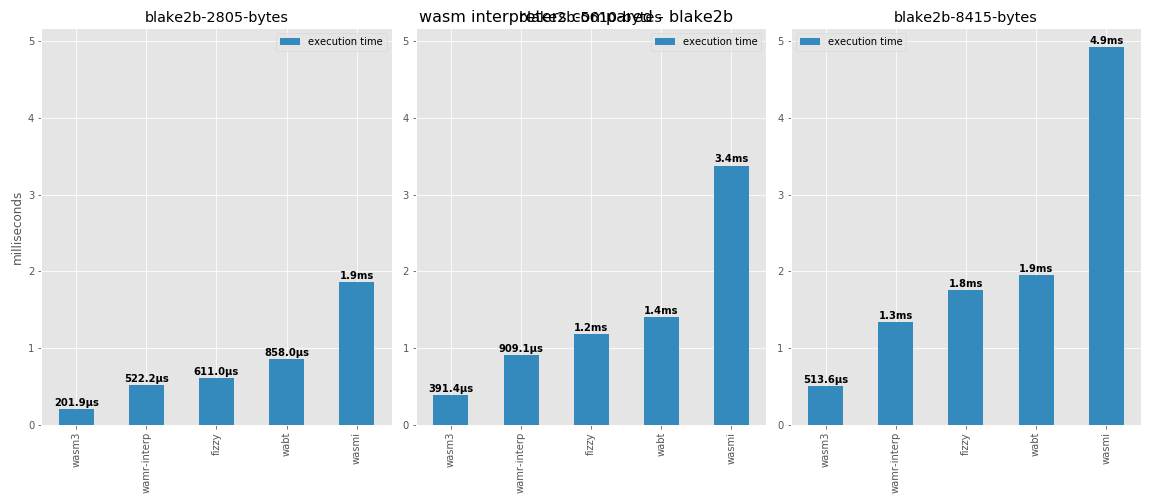

In [85]:
plotThreeTestsExecTime(df_interp,
                       blake2b_test_names,
                       title="wasm interpreters compared - blake2b",
                       filter_engines=["life", "wagon", "v8-interpreter"])

<Figure size 432x288 with 0 Axes>

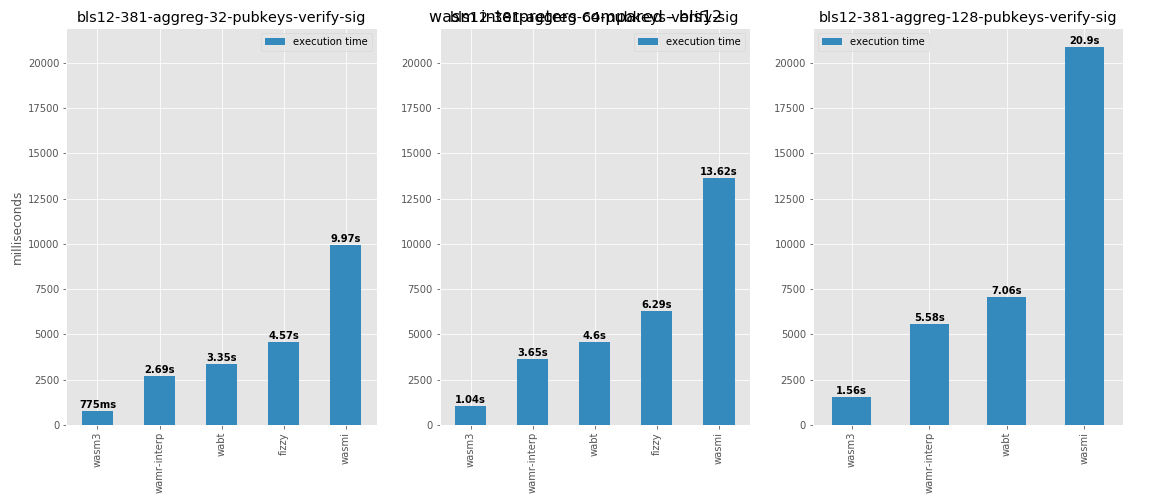

In [86]:
plotThreeTestsExecTime(df_interp,
                       bls12_test_names,
                       title="wasm interpreters compared - bls12",
                       filter_engines=["life", "wagon", "v8-interpreter"])

## Compiler Results

In [87]:
compiler_results_for_df = []
for engine in COMPILER_ENGINES:
    df_engine = df_wasm[df_wasm['engine'] == engine]
    df_means = df_engine.groupby(['test_name']).mean()
    test_names = df_engine['test_name'].unique().tolist()
    for test_name in test_names:
        compiler_results_for_df.append([engine, test_name] + df_means.loc[test_name].tolist())




In [88]:
df_compiler = pd.DataFrame(compiler_results_for_df)

df_compiler.columns = ['engine', 'test_name', 'elapsed_time', 'compile_time', 'exec_time']
df_compiler.set_index('engine', inplace=True)
df_compiler['total_time'] = df_compiler['compile_time'] + df_compiler['exec_time']

#df_compiler

## Compiler function

*Note: Fix scale for v8-turbofan execution time*

In [89]:
def plotCompilerStackedOneTest(df_benchdata, test_name):
    df_1 = df_benchdata[df_benchdata['test_name'] == test_name]
    # for some reason, exec_time needs to come first for the stacked chart to display correctly
    ax = df_1[['exec_time', 'compile_time']].sort_values('exec_time').plot.bar(stacked=True, color=[COLORS_DEFAULT['blue'], COLORS_DEFAULT['red']], figsize=(10,10))
    ax.set_title("Compilers - {}".format(test_name))
    df_total_times = df_1[['exec_time', 'compile_time']].copy()
    df_total_times['total_time'] = df_total_times['exec_time'] + df_total_times['compile_time']
    ymax = max(df_total_times[['total_time']].max()) * 1.3 # 30% larger for padding between top of bars and top of graph
    ymin = min([x for x in df_1[['exec_time', 'compile_time']].min().tolist() if x > 0])
    ymin = ymin * 0.8 # 0.8 to get a number 20% smaller, fix to make bar appear for smallest exec time
    ax.set_ylim(ymin, ymax)
    ax.set_yscale("log")
    plt.ylabel("seconds (log scale)")
    adjust_text_labels(labelBarHeights(ax, lower_y_bound=False))
    ax.legend(labels=["execution time", "compile time"])
    #plt.savefig("../images/wasm-compilers.png")
    plt.tight_layout()
    plt.show()


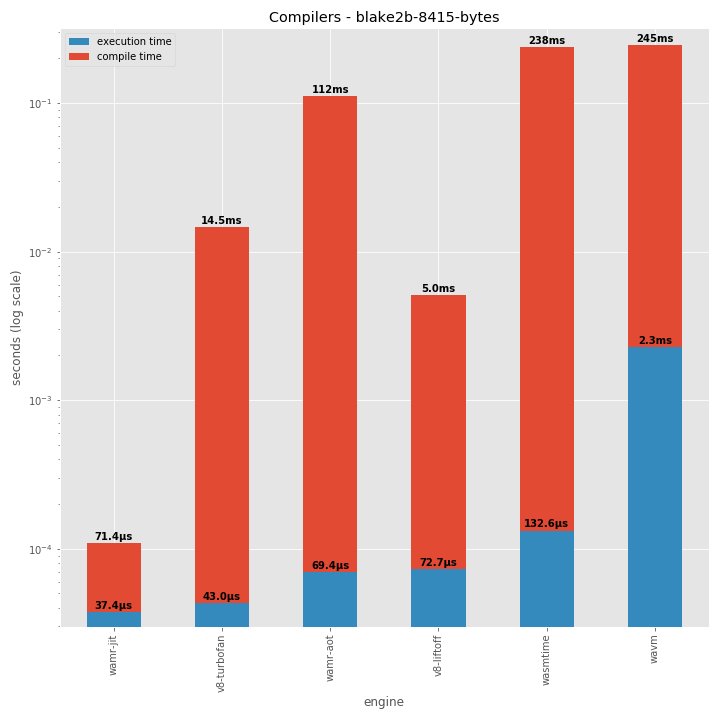

In [90]:
plotCompilerStackedOneTest(df_compiler, "blake2b-8415-bytes")

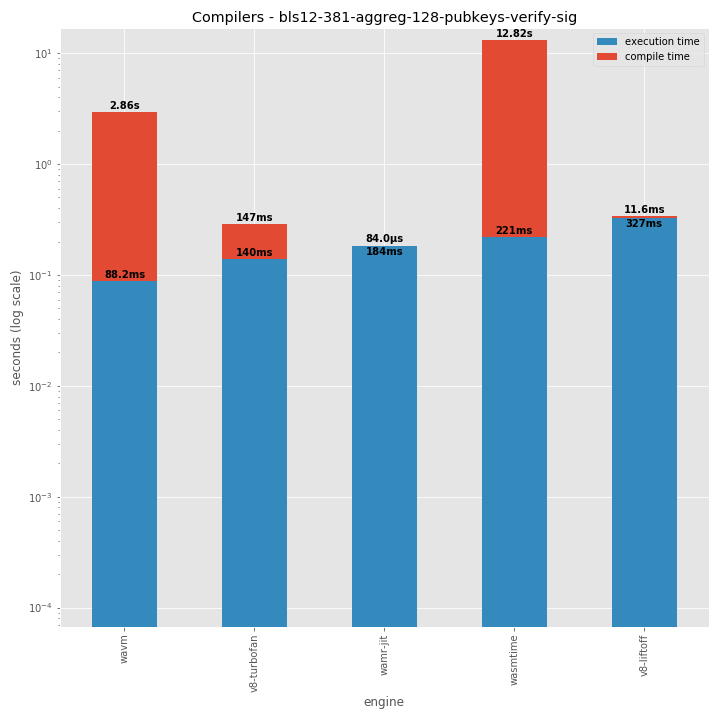

In [91]:
plotCompilerStackedOneTest(df_compiler, "bls12-381-aggreg-128-pubkeys-verify-sig")

## Add rust-native to compiler engines chart

In [92]:
# merge df_native and df_compiler into one dataframe
# both dataframes must have same columns to merge them:
# engine, test_name, elapsed_time, compile_time, exec_time, total_time

df_native_merge = df_native.copy()
df_native_merge.reset_index(inplace=True)
df_native_merge.columns = ['test_name', 'elapsed_time', 'engine']
df_native_merge['compile_time'] = 0
df_native_merge['exec_time'] = df_native_merge['elapsed_time']
df_native_merge['total_time'] = df_native_merge['elapsed_time']
df_native_and_compile = pd.concat([df_compiler.reset_index(), df_native_merge], sort=False)
df_native_and_compile.reset_index(drop=True, inplace=True)
df_native_and_compile.set_index('engine', inplace=True)


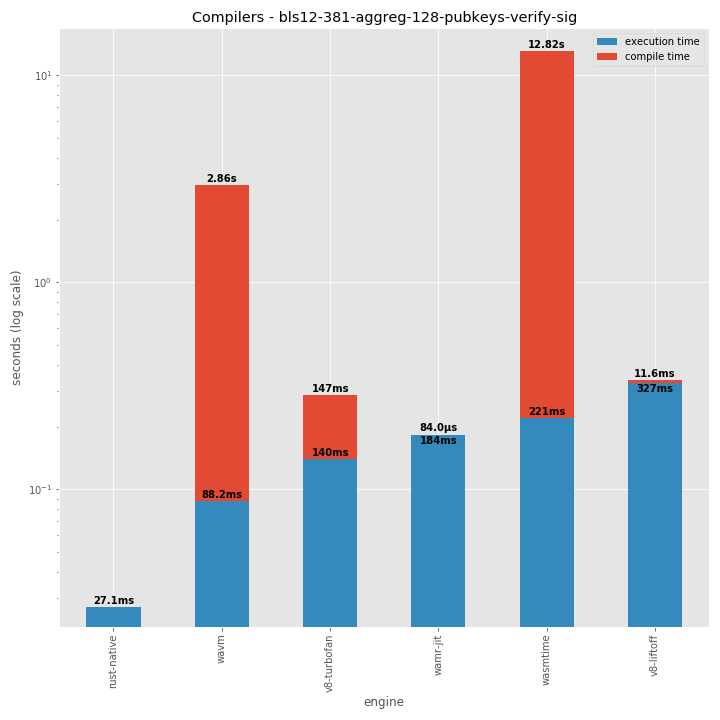

In [93]:
plotCompilerStackedOneTest(df_native_and_compile, "bls12-381-aggreg-128-pubkeys-verify-sig")

## Interpreter vs Compiler speedup

In [94]:
# merge df_compiler and df_interp
df_interp_merge = df_interp.copy()
df_interp_merge.columns = ['test_name', 'elapsed_time', 'compile_time', 'exec_time', 'total_time']
df_interp_and_compile = pd.concat([df_interp_merge, df_compiler])
df_interp_and_compile = df_interp_and_compile.reset_index()

In [95]:
def add_engine_ratio_col(df_two_engines, interp_engine, compiler_engine):
    df_two = df_two_engines.copy(deep=True)
    df_interp = df_two[df_two['engine'] == interp_engine].copy()
    df_compile = df_two[df_two['engine'] == compiler_engine]
    for index, row in df_interp.iterrows():
        test_name = row['test_name']
        row_compiler = df_compile[df_compile['test_name'] == test_name]
        if len(row_compiler) != 1:
            print("ERROR. SHOULD HAVE 1 MATCH ONLY")
            break
        compiler_exec_time = row_compiler.iloc[0]['exec_time']
        exec_ratio = row['exec_time'] / compiler_exec_time
        df_interp.at[index, 'compiler_exec_time'] = compiler_exec_time
        df_interp.at[index, 'interp_slowdown'] = exec_ratio

    return df_interp

In [96]:
df_wabt_v8liftoff = add_engine_ratio_col(df_interp_and_compile, "wabt", "v8-liftoff")

In [97]:
def plotCompilerSpeedup(df_compiler_speedup, interp_name="interp", compiler_name="compiler"):
    df_is = df_compiler_speedup.copy()
    plot_tests = df_is['test_name'].tolist()
    test_index = all_tests.copy()
    for test_name in all_tests:
        if test_name not in plot_tests:
            test_index.remove(test_name)
 
    df_is = df_is.set_index('test_name')
    df_is = df_is.reindex(test_index)
    plt.figure()
    ax = df_is['interp_slowdown'].plot.bar(figsize=(13,7), color=COLORS_DEFAULT['blue'])
    ax.set_title("{} (Interpreter) vs {} (Compiler) - speedup".format(interp_name, compiler_name))
    ax.set(ylabel="compiler speedup (log scale)", xlabel="")

    y_max = ax.get_ylim()[1]
    y_max = y_max * 5 # padding between top of bars and legend
    ax.set_yscale('log')
    ax.set_ylim(0.1, y_max) # adjustment to move horizontal line higher on chart

    adjust_text_labels(labelBarHeights(ax, to_ms=False, to_factor=1, lower_y_bound=False))

    plt.axhline(y=1.0, linewidth=2, ls='--', color='r')

    handles, _ = ax.get_legend_handles_labels()

    plt.legend(labels=["compiler engine is faster (ratio > 1x)", "compiler speedup \n (ratio: interp_exec_time/compiler_exec_time)"])

    #f.suptitle(title, fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()


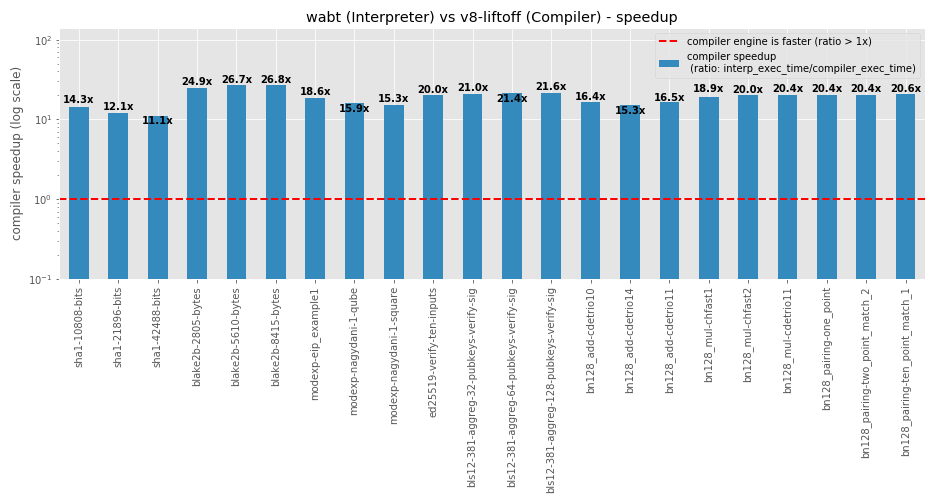

In [98]:
plotCompilerSpeedup(df_wabt_v8liftoff, interp_name="wabt", compiler_name="v8-liftoff")

## All precompiles compared (are interpreters feasible?)

In [99]:
def plotInterpOneEngine(df_benchdata, engine, test_names, title=""):
    df_bench = df_benchdata.loc[engine][df_benchdata.loc[engine]['test_name'].isin(test_names)]
    df_bench.set_index('test_name', inplace=True)
    df_bench = df_bench.reindex(test_names)
    plt.figure()
    ax = df_bench[['parse_time', 'exec_time']].plot.bar(stacked=True, figsize=(15,7), color=[COLORS_DEFAULT['red'], COLORS_DEFAULT['blue']])
    plt.ylabel("seconds")
    ax.set(xlabel='')
    # doing get_legend_handles_labels() so we can control the order of the labels in the legend 
    handles, labels = ax.get_legend_handles_labels()
    plt.legend([handles[1], handles[0]], ['execution time (top bar/label)', 'startup time (bottom bar/label - bar not visible for times < 20.0ms)'])
    adjust_text_labels(labelBarHeights(ax))
    plt.suptitle(title, fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

<Figure size 432x288 with 0 Axes>

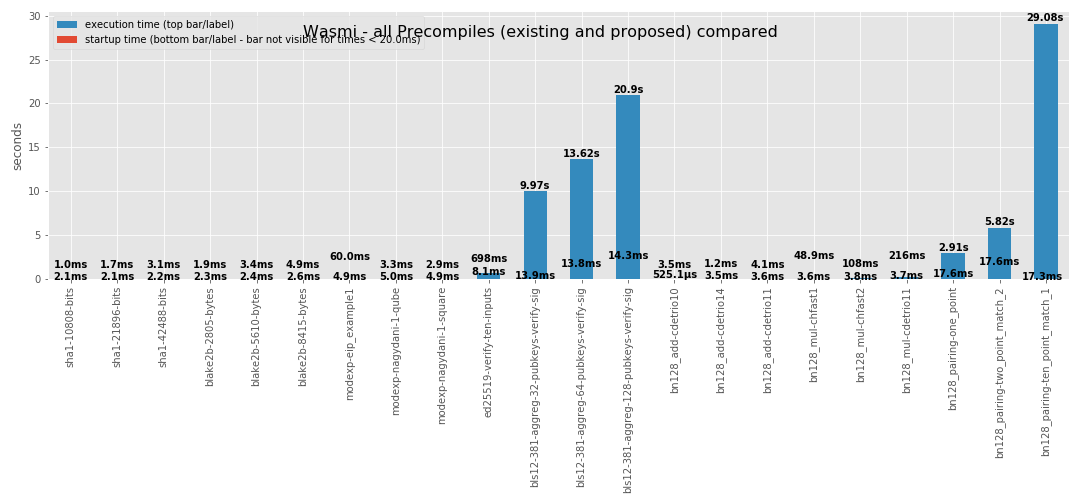

In [100]:
plotInterpOneEngine(df_interp, 'wasmi', all_tests, "Wasmi - all Precompiles (existing and proposed) compared")

<Figure size 432x288 with 0 Axes>

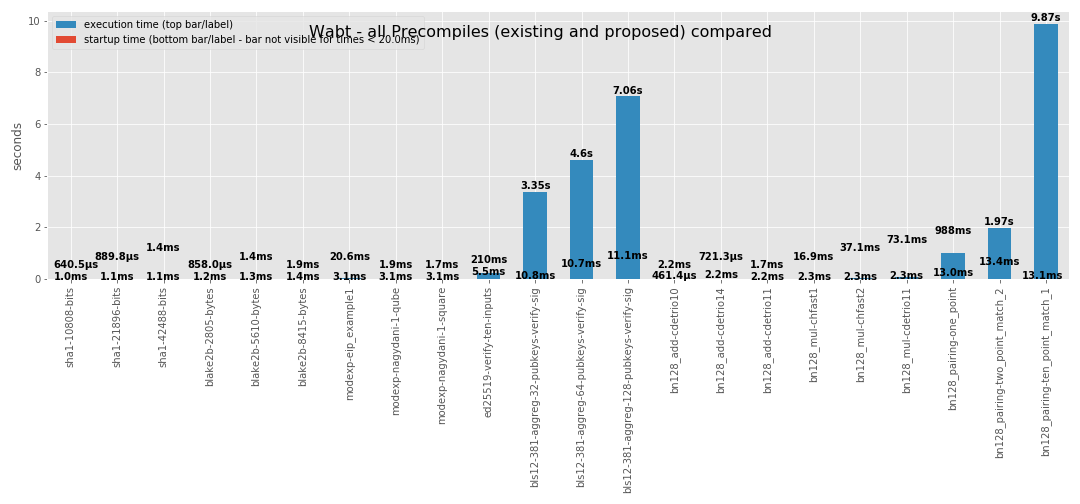

In [101]:
plotInterpOneEngine(df_interp, 'wabt', all_tests, "Wabt - all Precompiles (existing and proposed) compared")

<Figure size 432x288 with 0 Axes>

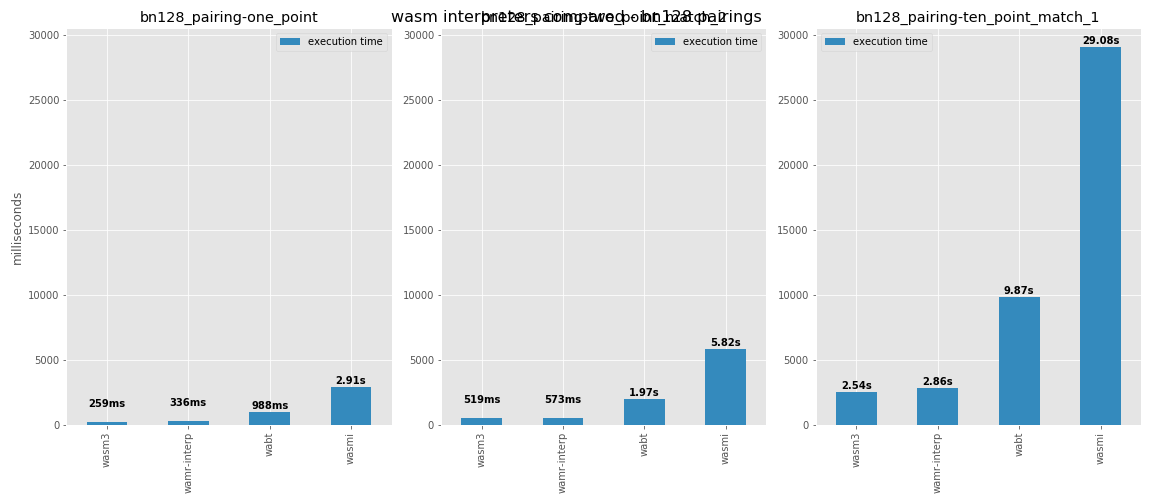

In [102]:
plotThreeTestsExecTime(df_interp,
                       bn128_pairing_test_names,
                       title="wasm interpreters compared - bn128 pairings",
                       filter_engines=["life", "wagon", "v8-interpreter"])

#### Are interpreter engines feasible for bn128 pairings?
TODO: highlight pairing two point match in interpreter engines



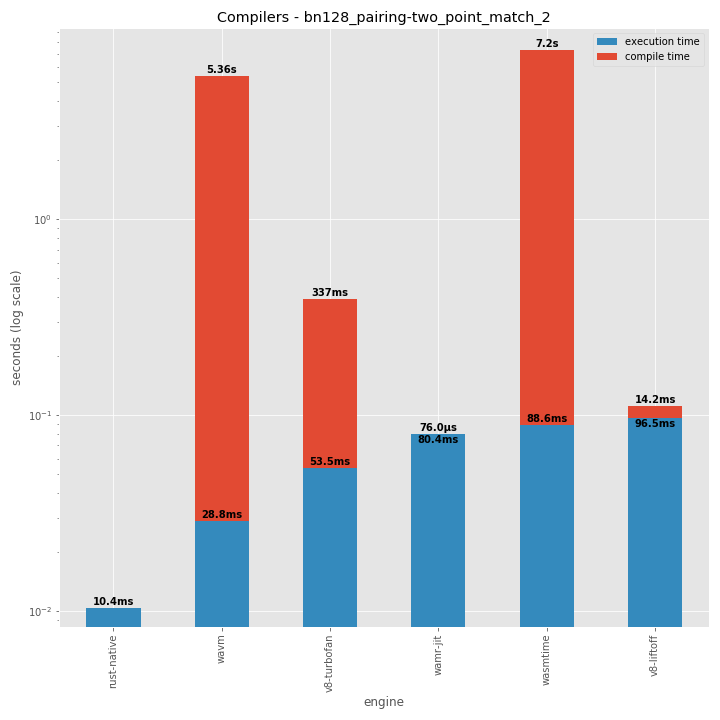

In [103]:
plotCompilerStackedOneTest(df_native_and_compile, "bn128_pairing-two_point_match_2")

#### Is any kind of wasm engine, interpreters or compilers, feasible for bn128 pairings?

V8-liftoff takes around 100ms, too slow relative to block processing time.

Can it be sped up? From profiling, we'd see that the bottleneck is bignum arithmetic. Maybe "native bignum methods", such as a mul256 opcode, would bring a significant speedup.

### add geth-native to df_scout_data for the rollup benchmark

In [104]:
df_geth_native_bn128pairing

,precompile_name,input_name,gas,time
57,PrecompiledBn256Pairing,two_point_match_rollup_input,113000,0.004205


In [105]:
df_geth_native_bn128pairing.loc[:, 'engine'] = "go-native"
df_geth_native_bn128pairing.loc[:, 'parse_time'] = 0

In [106]:
df_geth_native_bn128pairing.rename(columns={'input_name':'bench_name','time':'exec_time'},inplace=True)
df_geth_native_bn128pairing.drop(['precompile_name'],axis=1,inplace=True)
df_geth_native_bn128pairing.drop(['gas'],axis=1,inplace=True)
df_geth_native_bn128pairing = df_geth_native_bn128pairing[['engine', 'bench_name', 'parse_time', 'exec_time']]

In [107]:
df_geth_native_bn128pairing.loc[:,'bench_name'] = 'ecpairing-zkrollup-go-native-bn128-two-pairings'

In [108]:
df_geth_native_bn128pairing

,engine,bench_name,parse_time,exec_time
57,go-native,ecpairing-zkrollup-go-native-bn128-two-pairings,0.0,0.004205


### rust-wasm: bignums optimization - basic bignums speedup (wabt-with-bignums)

In [109]:
df_scout_rolluprs_bn128_pairings = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-rust-wasm-bn128-two-pairings']

df_rolluprs_native = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-rust-native-bn128-two-pairings']
df_rolluprs_native = df_rolluprs_native.fillna(0)
df_rolluprs_native = df_rolluprs_native.append(df_geth_native_bn128pairing)

df_scout_rolluprs = df_scout_rolluprs_bn128_pairings.append(df_rolluprs_native)
print(df_scout_rolluprs['engine'].unique().tolist())


['wabt-no-bignums', 'wabt-bignums-slowhost-slowmont', 'wabt-bignums-slowhost-slowmont-superops', 'wabt-bignums-fasthost-slowmont-superops', 'wabt-bignums-fasthost-fastmont-superops', 'v8-turbofan', 'v8-liftoff', 'v8-liftoff-and-turbofan', 'rust-native', 'go-native']


In [110]:
df_scout_rolluprs = df_scout_rolluprs[df_scout_rolluprs['engine'].isin(
    ['go-native', 'rust-native', 'v8-liftoff', 'v8-turbofan', 'wabt-bignums-slowhost-slowmont', 'wabt-no-bignums']
)]
    
df_scout_rolluprs.replace('wabt-bignums-slowhost-slowmont', 'wabt-with-bignums', inplace=True)

df_scout_means_rolluprs = df_scout_rolluprs.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

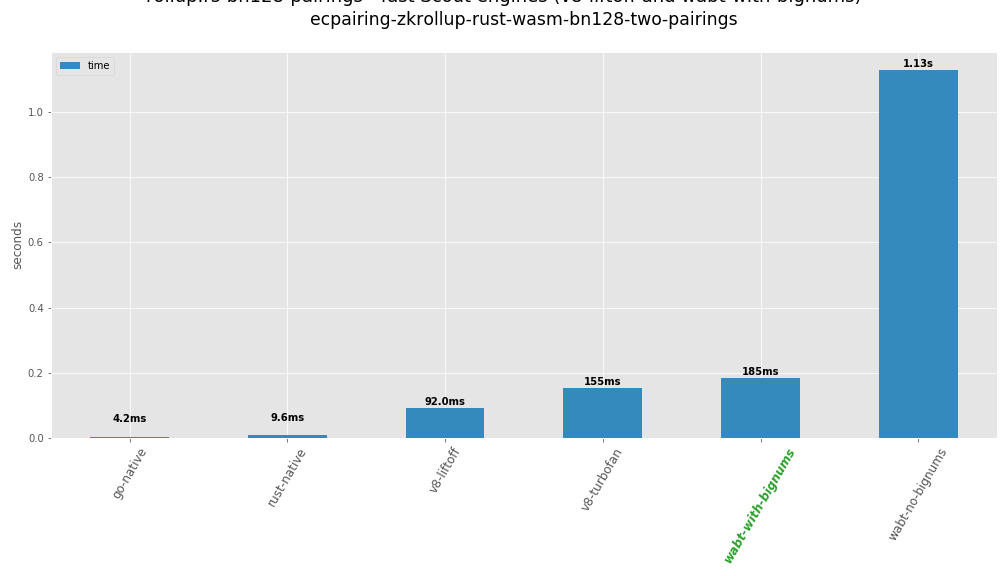

In [111]:

plotOneTestColoredTicks(df_scout_means_rolluprs,
            suptitle="rollup.rs-bn128-pairings - fast Scout engines (v8-liftoff and wabt-with-bignums)",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-rust-wasm-bn128-two-pairings\n",
            subtitle_size='xx-large',
            highlight_tick="wabt-with-bignums")


#### Are interpreter engines feasible, given an API for fast bignums?

From wabt-no-bignums at 1.18s, adding a bignum API achieves a 5x+ speedup to 172ms! Our interpreter is about 2x slower than a fast JIT engine, v8-liftoff at 91ms. Is there any way to speed it up?




### rust-wasm: remove wabt-no-bignums from chart.  compare only wabt-with-bignums vs compilers

In [112]:
df_scout_rolluprs_bn128_pairings = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-rust-wasm-bn128-two-pairings']

df_rolluprs_native = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-rust-native-bn128-two-pairings']
df_rolluprs_native = df_rolluprs_native.fillna(0)
df_rolluprs_native = df_rolluprs_native.append(df_geth_native_bn128pairing)
df_scout_rolluprs = df_scout_rolluprs_bn128_pairings.append(df_rolluprs_native)

df_scout_rolluprs = df_scout_rolluprs[df_scout_rolluprs['engine'].isin(
    ['go-native', 'rust-native', 'v8-liftoff', 'v8-turbofan', 'wabt-bignums-slowhost-slowmont']
)]

df_scout_rolluprs.replace('wabt-bignums-slowhost-slowmont', 'wabt-with-bignums', inplace=True)

df_scout_means_rolluprs = df_scout_rolluprs.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

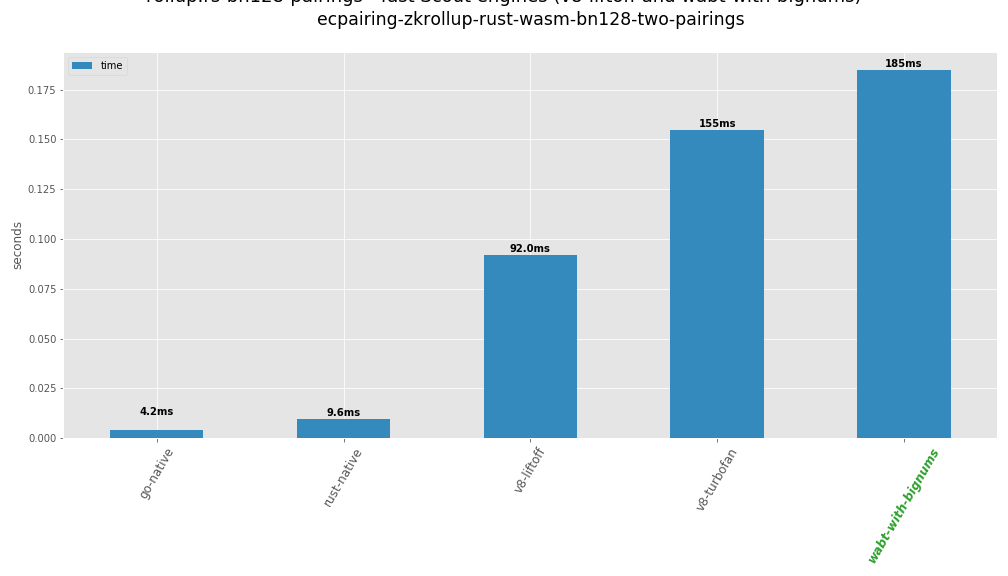

In [113]:
plotOneTestColoredTicks(df_scout_means_rolluprs,
            suptitle="rollup.rs-bn128-pairings - fast Scout engines (v8-liftoff and wabt-with-bignums)",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-rust-wasm-bn128-two-pairings\n",
            subtitle_size='xx-large',
            highlight_tick="wabt-with-bignums")


### rust-wasm: Superops optimization

In [114]:
df_scout_rolluprs_bn128_pairings = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-rust-wasm-bn128-two-pairings']
df_rolluprs_native = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-rust-native-bn128-two-pairings']
df_rolluprs_native = df_rolluprs_native.fillna(0)
df_rolluprs_native = df_rolluprs_native.append(df_geth_native_bn128pairing)
df_scout_rolluprs = df_scout_rolluprs_bn128_pairings.append(df_rolluprs_native)

print(df_scout_rolluprs['engine'].unique().tolist())

['wabt-no-bignums', 'wabt-bignums-slowhost-slowmont', 'wabt-bignums-slowhost-slowmont-superops', 'wabt-bignums-fasthost-slowmont-superops', 'wabt-bignums-fasthost-fastmont-superops', 'v8-turbofan', 'v8-liftoff', 'v8-liftoff-and-turbofan', 'rust-native', 'go-native']


In [115]:
df_scout_rolluprs = df_scout_rolluprs[df_scout_rolluprs['engine'].isin(
    ['go-native', 'rust-native', 'v8-liftoff', 'v8-turbofan', 'wabt-bignums-slowhost-slowmont', 'wabt-bignums-slowhost-slowmont-superops']
)]

df_scout_rolluprs.replace('wabt-bignums-slowhost-slowmont', 'wabt-with-bignums', inplace=True)
df_scout_rolluprs.replace('wabt-bignums-slowhost-slowmont-superops', 'wabt-bignums-superops', inplace=True)

df_scout_means_rolluprs = df_scout_rolluprs.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

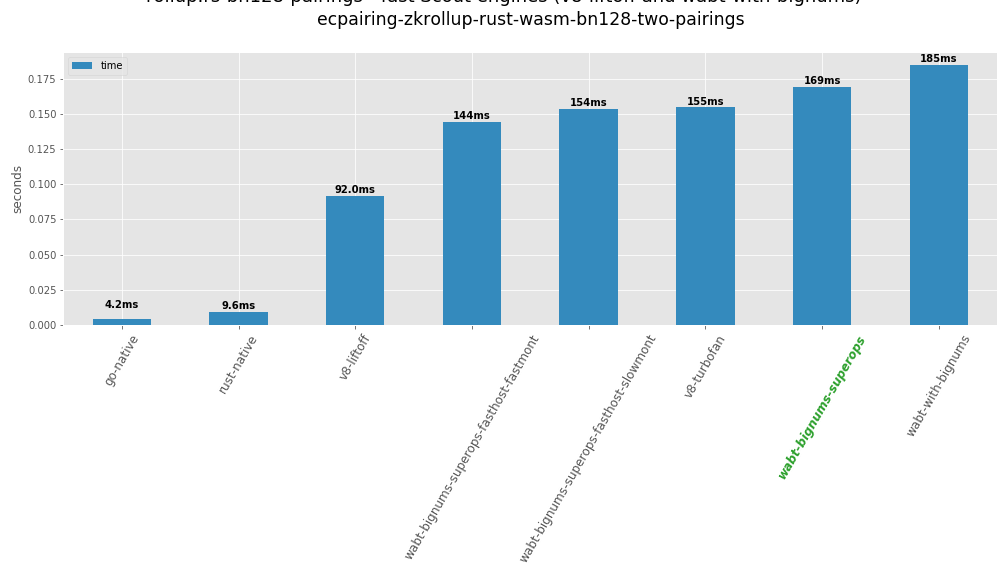

In [135]:

plotOneTestColoredTicks(df_scout_means_rolluprs,
            suptitle="rollup.rs-bn128-pairings - fast Scout engines (v8-liftoff and wabt-with-bignums)",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-rust-wasm-bn128-two-pairings\n",
            subtitle_size='xx-large',
            highlight_tick="wabt-bignums-superops")


### rust-wasm: in addition to superops, plot combied superops + fasthost, and superops + fasthost + fastmont

In [117]:
df_scout_rolluprs_bn128_pairings = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-rust-wasm-bn128-two-pairings']
df_rolluprs_native = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-rust-native-bn128-two-pairings']
df_rolluprs_native = df_rolluprs_native.fillna(0)
df_rolluprs_native = df_rolluprs_native.append(df_geth_native_bn128pairing)
df_scout_rolluprs = df_scout_rolluprs_bn128_pairings.append(df_rolluprs_native)

df_scout_rolluprs = df_scout_rolluprs[df_scout_rolluprs['engine'].isin(
    ['go-native', 'rust-native', 'v8-liftoff', 'v8-turbofan', 'wabt-bignums-slowhost-slowmont', 'wabt-bignums-slowhost-slowmont-superops', 'wabt-bignums-fasthost-slowmont-superops', 'wabt-bignums-fasthost-fastmont-superops']
)]

df_scout_rolluprs.replace('wabt-bignums-slowhost-slowmont', 'wabt-with-bignums', inplace=True)
df_scout_rolluprs.replace('wabt-bignums-slowhost-slowmont-superops', 'wabt-bignums-superops', inplace=True)
df_scout_rolluprs.replace('wabt-bignums-fasthost-slowmont-superops', 'wabt-bignums-superops-fasthost-slowmont', inplace=True)
df_scout_rolluprs.replace('wabt-bignums-fasthost-fastmont-superops', 'wabt-bignums-superops-fasthost-fastmont', inplace=True)

df_scout_means_rolluprs = df_scout_rolluprs.groupby(['engine']).mean()



<Figure size 432x288 with 0 Axes>

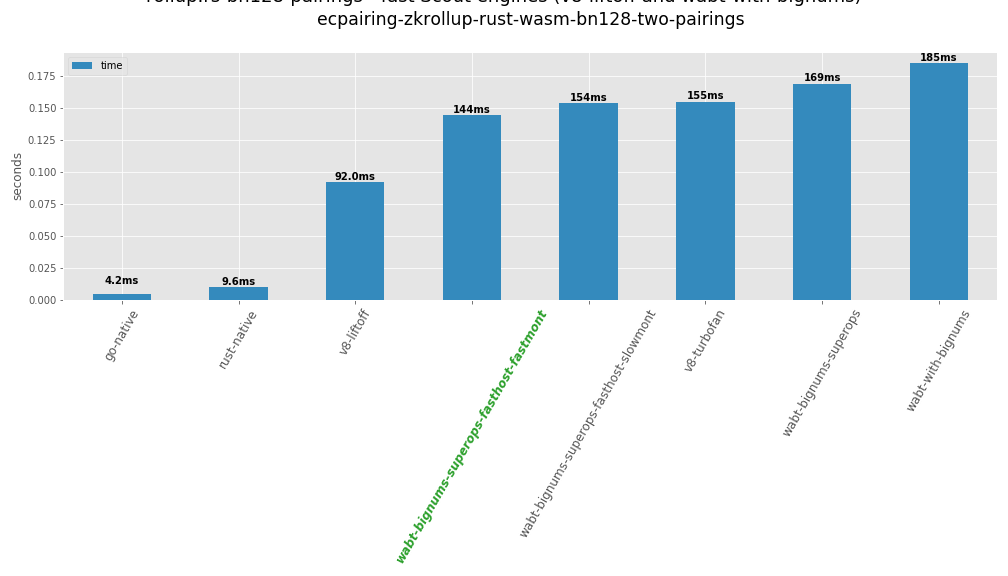

In [118]:
plotOneTestColoredTicks(df_scout_means_rolluprs,
            suptitle="rollup.rs-bn128-pairings - fast Scout engines (v8-liftoff and wabt-with-bignums)",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-rust-wasm-bn128-two-pairings\n",
            subtitle_size='xx-large',
            highlight_tick="wabt-bignums-superops-fasthost-fastmont")


### Optimization: websnark-wasm vs rust-wasm

In [119]:
df_scout_rust_vs_websnark = df_scout_data[
    df_scout_data['bench_name'].isin(
        ['ecpairing-zkrollup-rust-wasm-bn128-two-pairings',
         'ecpairing-zkrollup-websnark-bn128-two-pairings']
    )
]

In [120]:
df_scout_rust_vs_websnark['engine'].unique().tolist()

['wabt-no-bignums',
 'wabt-bignums-slowhost-slowmont',
 'wabt-bignums-slowhost-slowmont-superops',
 'wabt-bignums-fasthost-slowmont-superops',
 'wabt-bignums-fasthost-fastmont-superops',
 'wabt-bignums-fasthost-fastmont',
 'v8-turbofan',
 'v8-liftoff',
 'v8-liftoff-and-turbofan',
 'v8-interpreter',
 'v8-turbofan-with-bignums',
 'v8-liftoff-with-bignums',
 'v8-interpreter-with-bignums']

In [121]:
df_scout_rust_vs_websnark = df_scout_data[
    df_scout_data['bench_name'].isin(
        ['ecpairing-zkrollup-rust-wasm-bn128-two-pairings',
         'ecpairing-zkrollup-websnark-bn128-two-pairings']
    )
].copy()

# simplify bench_names to rust-wasm and websnark-wasm
df_scout_rust_vs_websnark.replace('ecpairing-zkrollup-rust-wasm-bn128-two-pairings', 'rust-wasm', inplace=True)
df_scout_rust_vs_websnark.replace('ecpairing-zkrollup-websnark-bn128-two-pairings', 'websnark-wasm', inplace=True)



df_scout_rust_vs_websnark = df_scout_rust_vs_websnark[df_scout_rust_vs_websnark['engine'].isin(
    ['go-native', 'rust-native', 'v8-liftoff', 'v8-turbofan', 'wabt-bignums-slowhost-slowmont', 'wabt-bignums-slowhost-slowmont-superops']
)]

# simplify wabt engine names
df_scout_rust_vs_websnark.replace('wabt-bignums-slowhost-slowmont', 'wabt-with-bignums', inplace=True)
df_scout_rust_vs_websnark.replace('wabt-bignums-slowhost-slowmont-superops', 'wabt-bignums-superops', inplace=True)



<Figure size 432x288 with 0 Axes>

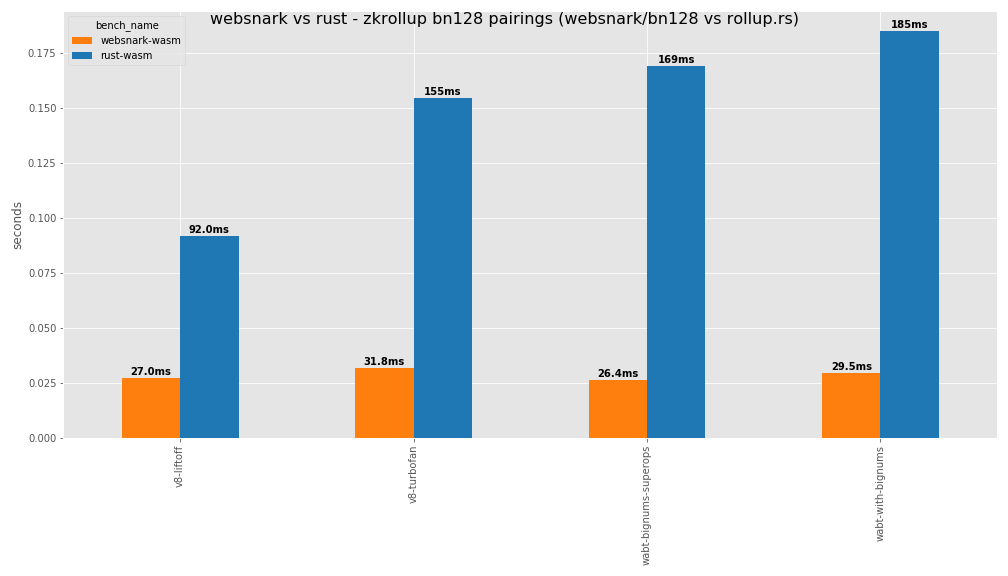

In [122]:
plotOneTestGrouped(df_scout_rust_vs_websnark,
                   title="websnark vs rust - zkrollup bn128 pairings (websnark/bn128 vs rollup.rs)",
                   test_title="",
                   group_order=['websnark-wasm', 'rust-wasm'],
                   sort_by=['rust-wasm'],
                   colors=['tab:orange', 'tab:blue'])


### drop rust-wasm, just plot websnark-wasm on different engines

### show on basic wabt-with-bignums and wabt-bignums-superops 

In [123]:
df_scout_websnark = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-websnark-bn128-two-pairings']
df_rolluprs_native = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-rust-native-bn128-two-pairings']
df_rolluprs_native = df_rolluprs_native.fillna(0)
df_rolluprs_native = df_rolluprs_native.append(df_geth_native_bn128pairing)
df_scout_websnark = df_scout_websnark.append(df_rolluprs_native)

df_scout_websnark = df_scout_websnark[df_scout_websnark['engine'].isin(
    ['go-native', 'rust-native', 'v8-liftoff', 'v8-turbofan', 'wabt-bignums-slowhost-slowmont', 'wabt-bignums-slowhost-slowmont-superops']
)]

df_scout_websnark.replace('wabt-bignums-slowhost-slowmont', 'wabt-with-bignums', inplace=True)
df_scout_websnark.replace('wabt-bignums-slowhost-slowmont-superops', 'wabt-bignums-superops', inplace=True)

df_scout_means_websnark = df_scout_websnark.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

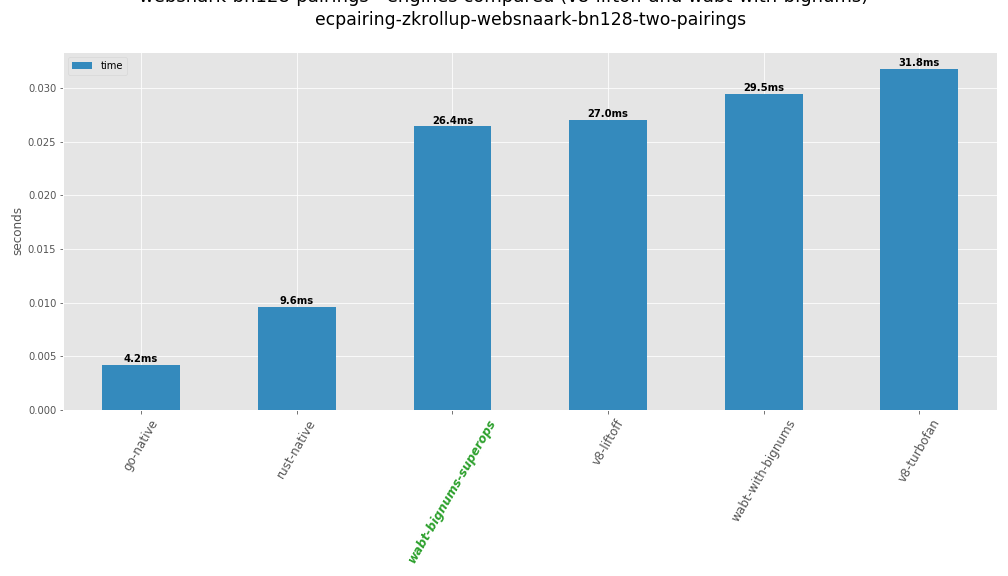

In [124]:
plotOneTestColoredTicks(df_scout_means_websnark,
            suptitle="websnark-bn128-pairings - engines compared (v8-liftoff and wabt-with-bignums)",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-websnaark-bn128-two-pairings\n",
            subtitle_size='xx-large',
            highlight_tick="wabt-bignums-superops")


### websnark-wasm optimization: "fast-host"


In [125]:
df_scout_websnark = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-websnark-bn128-two-pairings']
df_rolluprs_native = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-rust-native-bn128-two-pairings']
df_rolluprs_native = df_rolluprs_native.fillna(0)
df_rolluprs_native = df_rolluprs_native.append(df_geth_native_bn128pairing)
df_scout_websnark = df_scout_websnark.append(df_rolluprs_native)

df_scout_websnark['engine'].unique().tolist()

['wabt-no-bignums',
 'wabt-bignums-slowhost-slowmont',
 'wabt-bignums-slowhost-slowmont-superops',
 'wabt-bignums-fasthost-slowmont-superops',
 'wabt-bignums-fasthost-fastmont-superops',
 'wabt-bignums-fasthost-fastmont',
 'v8-turbofan',
 'v8-liftoff',
 'v8-liftoff-and-turbofan',
 'v8-interpreter',
 'v8-turbofan-with-bignums',
 'v8-liftoff-with-bignums',
 'v8-interpreter-with-bignums',
 'rust-native',
 'go-native']

In [126]:
df_scout_websnark = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-websnark-bn128-two-pairings']
df_rolluprs_native = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-rust-native-bn128-two-pairings']
df_rolluprs_native = df_rolluprs_native.fillna(0)
df_rolluprs_native = df_rolluprs_native.append(df_geth_native_bn128pairing)
df_scout_websnark = df_scout_websnark.append(df_rolluprs_native)

#df_scout_websnark.replace('ecpairing-zkrollup-rust-native-bn128-two-pairings', 'rust-native', inplace=True)
#df_scout_websnark.replace('ecpairing-zkrollup-websnark-bn128-two-pairings', 'websnark-wasm', inplace=True)

df_scout_websnark = df_scout_websnark[df_scout_websnark['engine'].isin(
    ['go-native', 'rust-native', 'v8-liftoff', 'v8-turbofan', 'wabt-bignums-slowhost-slowmont',
     'wabt-bignums-slowhost-slowmont-superops', 'wabt-bignums-slowhost-slowmont-superops',
    'wabt-bignums-fasthost-slowmont-superops']
)]

df_scout_websnark.replace('wabt-bignums-slowhost-slowmont', 'wabt-with-bignums', inplace=True)
df_scout_websnark.replace('wabt-bignums-slowhost-slowmont-superops', 'wabt-bignums-superops', inplace=True)
df_scout_websnark.replace('wabt-bignums-fasthost-slowmont-superops', 'wabt-bignums-superops-fasthost', inplace=True)

df_scout_means_websnark = df_scout_websnark.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

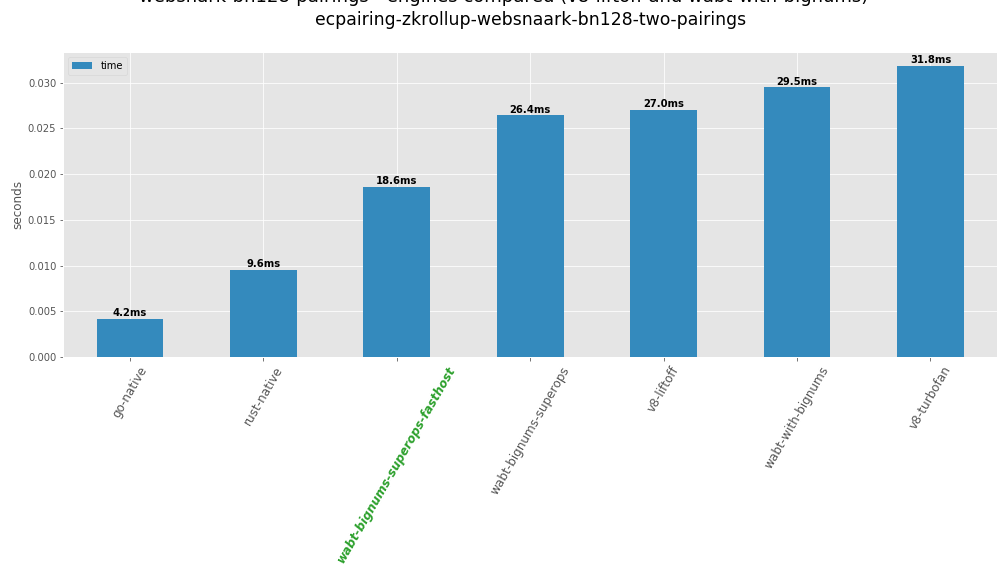

In [127]:
plotOneTestColoredTicks(df_scout_means_websnark,
            suptitle="websnark-bn128-pairings - engines compared (v8-liftoff and wabt-with-bignums)",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-websnaark-bn128-two-pairings\n",
            subtitle_size='xx-large',
            highlight_tick="wabt-bignums-superops-fasthost")


### websnark-wasm optimization: interleaved montgomery

In [128]:
df_scout_websnark = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-websnark-bn128-two-pairings']
df_rolluprs_native = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-rust-native-bn128-two-pairings']
df_rolluprs_native = df_rolluprs_native.fillna(0)
df_rolluprs_native = df_rolluprs_native.append(df_geth_native_bn128pairing)
df_scout_websnark = df_scout_websnark.append(df_rolluprs_native)

df_scout_websnark = df_scout_websnark[df_scout_websnark['engine'].isin(
    ['go-native', 'rust-native', 'v8-liftoff', 'v8-turbofan', 'wabt-bignums-slowhost-slowmont',
     'wabt-bignums-slowhost-slowmont-superops', 'wabt-bignums-slowhost-slowmont-superops',
    'wabt-bignums-fasthost-slowmont-superops', 'wabt-bignums-fasthost-fastmont-superops']
)]

df_scout_websnark.replace('wabt-bignums-slowhost-slowmont', 'wabt-with-bignums', inplace=True)
df_scout_websnark.replace('wabt-bignums-slowhost-slowmont-superops', 'wabt-bignums-superops', inplace=True)
df_scout_websnark.replace('wabt-bignums-fasthost-slowmont-superops', 'wabt-bignums-superops-fasthost', inplace=True)
df_scout_websnark.replace('wabt-bignums-fasthost-fastmont-superops', 'wabt-bignums-superops-fasthost-fastmont', inplace=True)

df_scout_means_websnark = df_scout_websnark.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

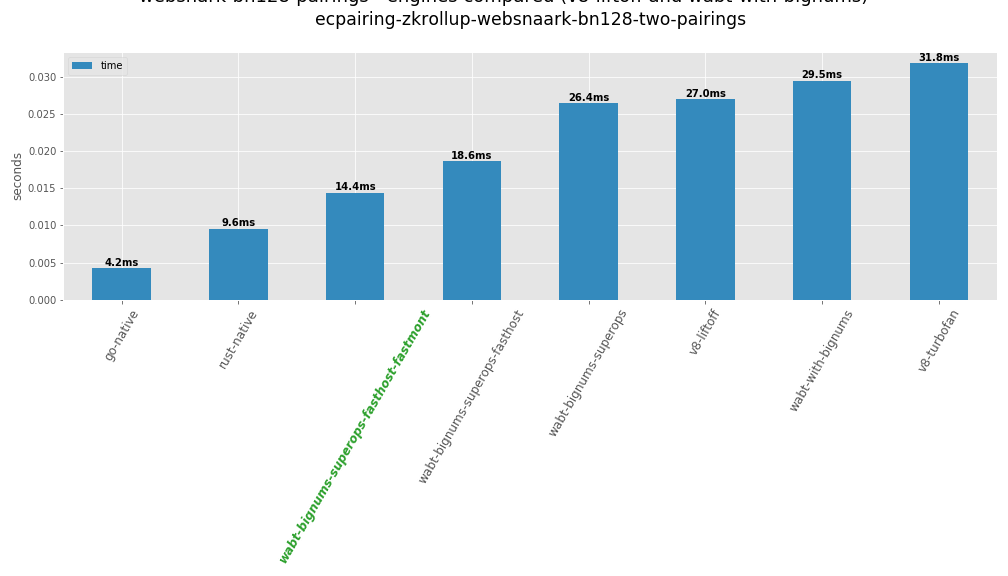

In [129]:
plotOneTestColoredTicks(df_scout_means_websnark,
            suptitle="websnark-bn128-pairings - engines compared (v8-liftoff and wabt-with-bignums)",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-websnaark-bn128-two-pairings\n",
            subtitle_size='xx-large',
            highlight_tick="wabt-bignums-superops-fasthost-fastmont")


### websnark-wasm: Show startup time and execution time, for interleaved montgomery and other optimizations

<Figure size 432x288 with 0 Axes>

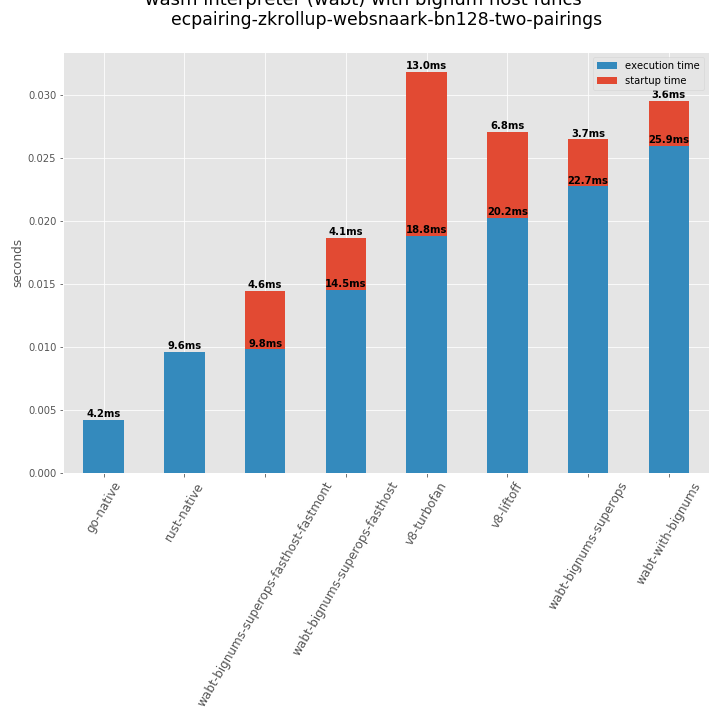

In [130]:
plotScoutStackedTest(df_scout_means_websnark,
            suptitle="wasm compilers - optimizing (v8-turbofan) and single-pass (v8-liftoff) \n vs. \n wasm interpreter (wabt) with bignum host funcs",
            suptitle_pos=1.07,
            subtitle="ecpairing-zkrollup-websnaark-bn128-two-pairings\n",
            subtitle_size='xx-large')

## EVM vs wasm shootout: blake2b

In [136]:
df_evm_raw

,engine,test_name,total_time,gas_used
0,evmone,sha1-10808-bits-shiftopt,0.001596,759.785k
1,parity-evm,sha1-10808-bits-shiftopt,0.022314,759785
2,geth-evm,sha1-10808-bits-shiftopt,0.017770,759785
3,cita-evm,sha1-10808-bits-shiftopt,0.012676,873117
4,evmone,sha1-21896-bits-shiftopt,0.003226,1.48425M
5,parity-evm,sha1-21896-bits-shiftopt,0.040143,1484254
6,geth-evm,sha1-21896-bits-shiftopt,0.035941,1484254
7,cita-evm,sha1-21896-bits-shiftopt,0.025492,1691062
8,evmone,sha1-42488-bits-shiftopt,0.006501,2.89847M
9,parity-evm,sha1-42488-bits-shiftopt,0.086442,2898473


In [137]:
df_interp

,test_name,elapsed_time,parse_time,exec_time,total_time
engine,,,,,
life,ecpairing,11.962463,0.066253,11.892367,11.958620
life,sha1-21896-bits,0.012746,0.007526,0.001763,0.009289
life,bn128_mul-chfast1,0.093026,0.032418,0.056760,0.089179
life,bn128_mul-cdetrio11,0.286032,0.031972,0.250127,0.282099
life,bn128_add-cdetrio10,0.035928,0.031594,0.000580,0.032174
life,blake2b-2805-bytes,0.016225,0.010851,0.001904,0.012755
life,bn128_mul-cdetrio7,0.247767,0.032383,0.211377,0.243760
life,bn128_mul-cdetrio12,0.247886,0.032373,0.211544,0.243917
life,bn128_mul-chfast3,0.256684,0.032479,0.220301,0.252780


In [ ]:
# df_evm_raw test_name="blake2b-8415-bytes"
# df_evm_raw test_name="blake2b_huff-8415-bytes"

# df_interp test_name="blake2b-8415-bytes"


`df_evm_vs_wasm_blake2b`
```
          engine	bench_name	parse_time	exec_time
1383	v8-turbofan	websnark-wasm	0.012526	0.019856
1384	v8-liftoff	websnark-wasm	0.006579	0.019689
1390	v8-turbofan	rust-wasm	0.020768	0.117253
1391	v8-liftoff	rust-wasm	0.014276	0.070435
1404	v8-turbofan	websnark-wasm	0.009650	0.021088
1405	v8-liftoff	websnark-wasm	0.008004	0.024127
```

In [198]:
df_evm_blake2b = df_evm_raw[df_evm_raw['test_name'].isin(['blake2b-8415-bytes', 'blake2b_huff-8415-bytes'])].copy()

In [199]:
#df_evm_blake2b

In [200]:
df_evm_blake2b.rename(columns={'test_name':'bench_name', 'total_time':'exec_time'},inplace=True)
df_evm_blake2b.drop(['gas_used'],axis=1,inplace=True)
df_evm_blake2b.loc[:, 'parse_time'] = 0
df_evm_blake2b = df_evm_blake2b[['engine', 'bench_name', 'parse_time', 'exec_time']]

In [202]:
df_evm_blake2b.replace('blake2b-8415-bytes', 'blake2b-8kb.sol.evm', inplace=True)
df_evm_blake2b.replace('blake2b_huff-8415-bytes', 'blake2b-8kb.huff.evm', inplace=True)

In [206]:
df_evm_blake2b

,engine,bench_name,parse_time,exec_time
24,evmone,blake2b-8kb.sol.evm,0,0.044307
25,parity-evm,blake2b-8kb.sol.evm,0,0.312272
26,geth-evm,blake2b-8kb.sol.evm,0,0.258288
27,cita-evm,blake2b-8kb.sol.evm,0,0.287592
72,evmone,blake2b-8kb.huff.evm,0,0.002448
73,parity-evm,blake2b-8kb.huff.evm,0,0.027909
74,geth-evm,blake2b-8kb.huff.evm,0,0.035076
75,cita-evm,blake2b-8kb.huff.evm,0,0.015140


In [203]:
df_wasm_blake2b = df_interp[df_interp['test_name'] == "blake2b-8415-bytes"].copy()

In [193]:
#df_wasm_blake2b

,test_name,elapsed_time,parse_time,exec_time,total_time
engine,,,,,
life,blake2b-8415-bytes,0.022081,0.013088,0.005415,0.018503
wagon,blake2b-8415-bytes,0.050761,0.042981,0.004840,0.047821
wasmi,blake2b-8415-bytes,0.009960,0.002642,0.004927,0.007568
wabt,blake2b-8415-bytes,0.006070,0.001404,0.001947,0.003351
v8-interpreter,blake2b-8415-bytes,0.069510,0.005882,0.005438,0.011320
wasm3,blake2b-8415-bytes,0.003269,0.000022,0.000514,0.000536
wamr-interp,blake2b-8415-bytes,0.004455,0.000558,0.001343,0.001901
fizzy,blake2b-8415-bytes,2.784678,0.000030,0.001753,0.001783


In [204]:
df_wasm_blake2b.rename(columns={'test_name':'bench_name'},inplace=True)
df_wasm_blake2b.drop(['elapsed_time'],axis=1,inplace=True)
df_wasm_blake2b.drop(['total_time'],axis=1,inplace=True)
#df_wasm_blake2b = df_wasm_blake2b[['engine', 'bench_name', 'parse_time', 'exec_time']]
df_wasm_blake2b.reset_index(inplace=True)
df_wasm_blake2b.replace('blake2b-8415-bytes', 'blake2b-8kb.rust.wasm', inplace=True)


In [205]:
df_wasm_blake2b

,engine,bench_name,parse_time,exec_time
0,life,blake2b-8kb.rust.wasm,0.013088,0.005415
1,wagon,blake2b-8kb.rust.wasm,0.042981,0.004840
2,wasmi,blake2b-8kb.rust.wasm,0.002642,0.004927
3,wabt,blake2b-8kb.rust.wasm,0.001404,0.001947
4,v8-interpreter,blake2b-8kb.rust.wasm,0.005882,0.005438
5,wasm3,blake2b-8kb.rust.wasm,0.000022,0.000514
6,wamr-interp,blake2b-8kb.rust.wasm,0.000558,0.001343
7,fizzy,blake2b-8kb.rust.wasm,0.000030,0.001753


In [210]:
df_evm_vs_wasm_blake2b = df_evm_blake2b.append(df_wasm_blake2b, sort=False).copy()

In [212]:
df_evm_vs_wasm_blake2b

,engine,bench_name,parse_time,exec_time
24,evmone,blake2b-8kb.sol.evm,0.000000,0.044307
25,parity-evm,blake2b-8kb.sol.evm,0.000000,0.312272
26,geth-evm,blake2b-8kb.sol.evm,0.000000,0.258288
27,cita-evm,blake2b-8kb.sol.evm,0.000000,0.287592
72,evmone,blake2b-8kb.huff.evm,0.000000,0.002448
73,parity-evm,blake2b-8kb.huff.evm,0.000000,0.027909
74,geth-evm,blake2b-8kb.huff.evm,0.000000,0.035076
75,cita-evm,blake2b-8kb.huff.evm,0.000000,0.015140
0,life,blake2b-8kb.rust.wasm,0.013088,0.005415
1,wagon,blake2b-8kb.rust.wasm,0.042981,0.004840


In [217]:
df_evm_vs_wasm_blake2b = df_evm_vs_wasm_blake2b[df_evm_vs_wasm_blake2b['engine'].isin(
    ['parity-evm', 'geth-evm', 'evmone', 'cita-evm',
    'wasmi', 'wabt', 'wamr-interp', 'fizzy', 'wasm3']
)].copy()

In [218]:
#df_scout_rust_vs_websnark.replace('ecpairing-zkrollup-rust-wasm-bn128-two-pairings', 'rust-wasm', inplace=True)
#df_scout_rust_vs_websnark.replace('ecpairing-zkrollup-websnark-bn128-two-pairings', 'websnark-wasm', inplace=True)

<Figure size 432x288 with 0 Axes>

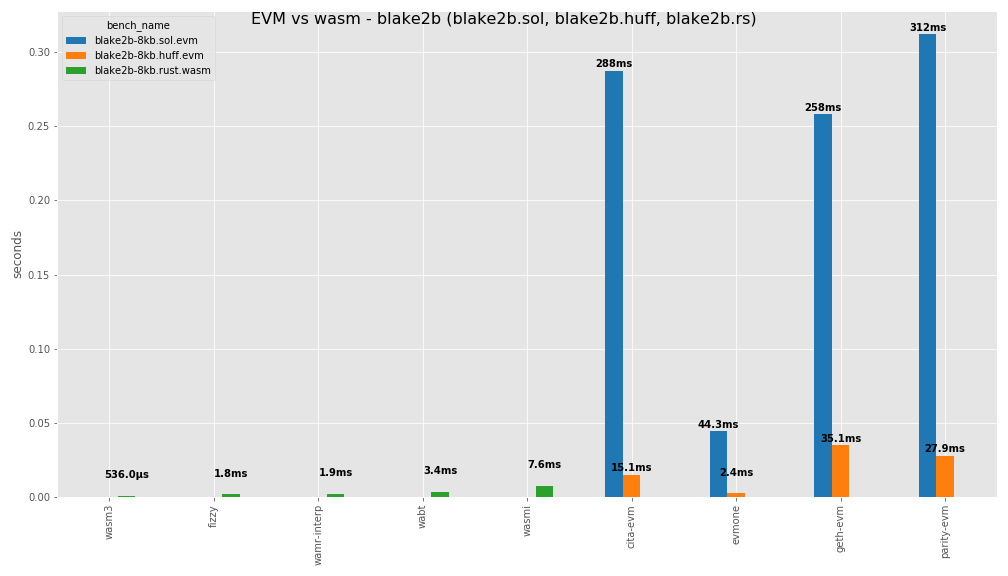

In [221]:

plotOneTestGrouped(df_evm_vs_wasm_blake2b,
                   title="EVM vs wasm - blake2b (blake2b.sol, blake2b.huff, blake2b.rs)",
                   test_title="",
                   group_order=['blake2b-8kb.sol.evm', 'blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm'],
                   sort_by="blake2b-8kb.rust.wasm",
                   colors=['tab:blue', 'tab:orange', 'tab:green'])


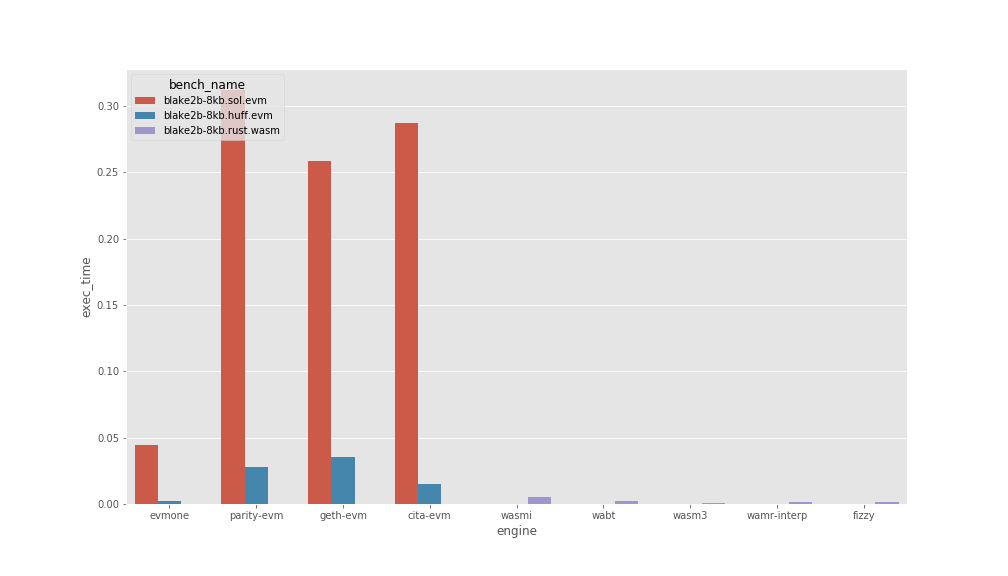

In [224]:
f = plt.figure(figsize=(14,8))

sns.barplot(x='engine', y='exec_time', hue='bench_name', dodge=True, data=df_evm_vs_wasm_blake2b)

In [229]:
df_evm_vs_wasm_blake2b = df_evm_vs_wasm_blake2b[df_evm_vs_wasm_blake2b['bench_name'].isin(
    ['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm']
)].copy()

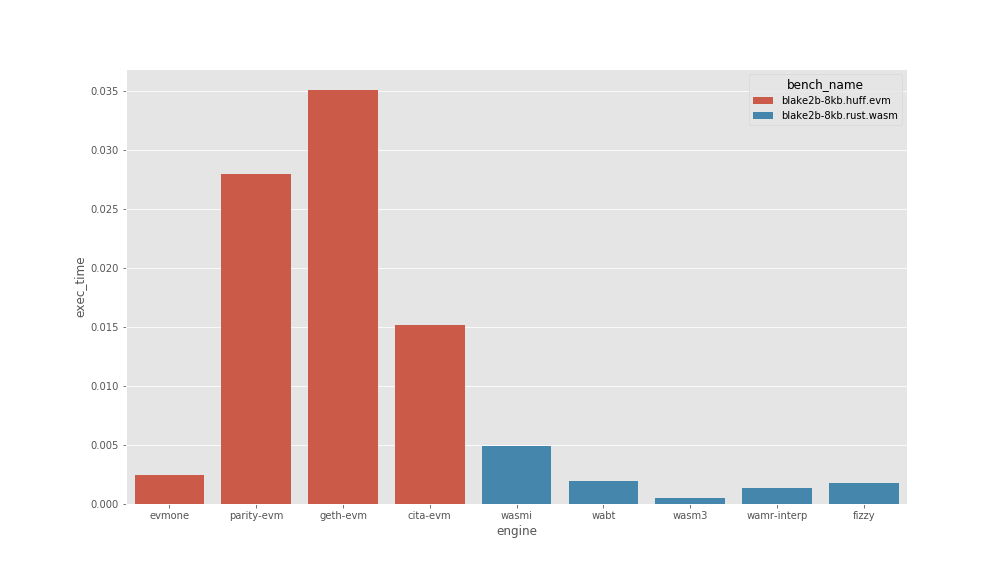

In [231]:
f = plt.figure(figsize=(14,8))

sns.barplot(x='engine', y='exec_time', hue='bench_name', dodge=False, data=df_evm_vs_wasm_blake2b)

In [232]:
titanic = sns.load_dataset('titanic')
print(titanic.head())

   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  


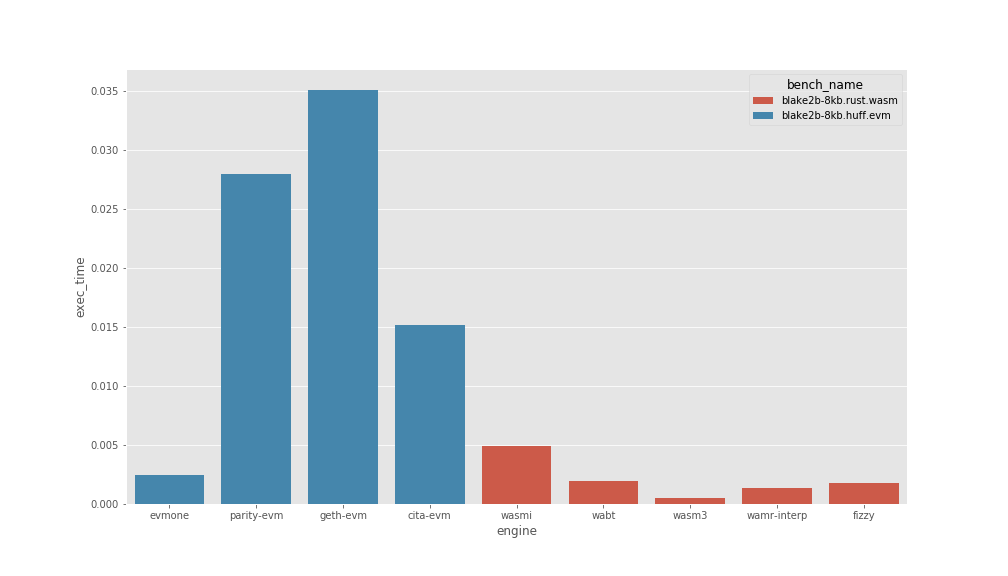

In [246]:
f = plt.figure(figsize=(14,8))

sns.barplot(x='engine', y='exec_time', hue='bench_name', dodge=False,
            #hue_order=['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm'],
            hue_order=['blake2b-8kb.rust.wasm', 'blake2b-8kb.huff.evm'],
            #order=['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm'],
            #order='exec_time',
            #order=[""]
            data=df_evm_vs_wasm_blake2b)

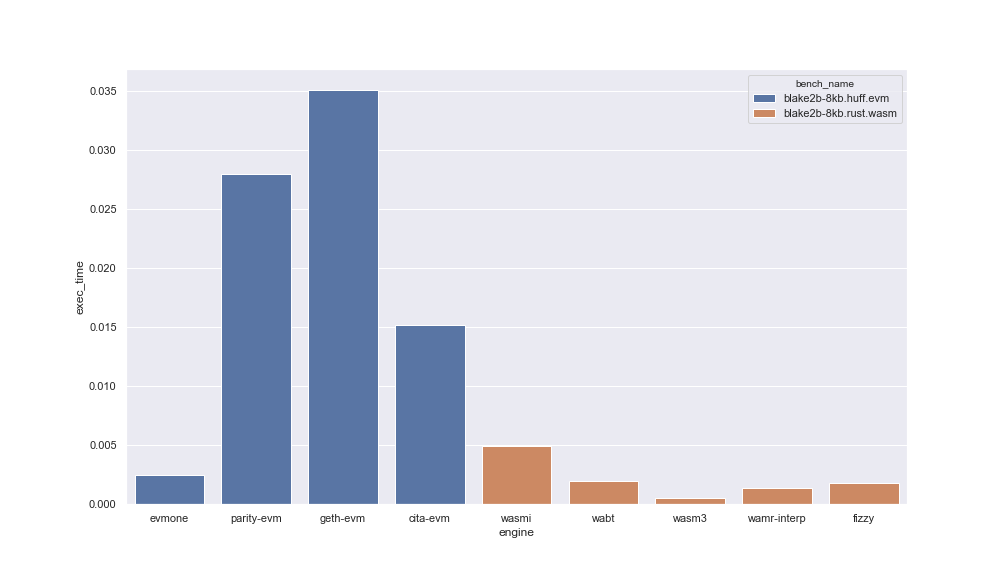

In [258]:
f = plt.figure(figsize=(14,8))

sns.barplot(x='engine', y='exec_time', hue='bench_name', dodge=False,
            #hue_order=['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm'],
            #hue_order=['blake2b-8kb.rust.wasm', 'blake2b-8kb.huff.evm'],
            #order=['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm'],
            #order='exec_time',
            #order=[""]
            data=df_evm_vs_wasm_blake2b)

In [248]:
df_evm_vs_wasm_blake2b

,engine,bench_name,parse_time,exec_time,time
72,evmone,blake2b-8kb.huff.evm,0.000000,0.002448,0.002448
73,parity-evm,blake2b-8kb.huff.evm,0.000000,0.027909,0.027909
74,geth-evm,blake2b-8kb.huff.evm,0.000000,0.035076,0.035076
75,cita-evm,blake2b-8kb.huff.evm,0.000000,0.015140,0.015140
2,wasmi,blake2b-8kb.rust.wasm,0.002642,0.004927,0.007568
3,wabt,blake2b-8kb.rust.wasm,0.001404,0.001947,0.003351
5,wasm3,blake2b-8kb.rust.wasm,0.000022,0.000514,0.000536
6,wamr-interp,blake2b-8kb.rust.wasm,0.000558,0.001343,0.001901
7,fizzy,blake2b-8kb.rust.wasm,0.000030,0.001753,0.001783


In [249]:
df_evm_vs_wasm_blake2b_sorted = df_evm_vs_wasm_blake2b.sort_values('time')

[Text(0, 0, 'wasm3'),
 Text(0, 0, 'fizzy'),
 Text(0, 0, 'wamr-interp'),
 Text(0, 0, 'evmone'),
 Text(0, 0, 'wabt'),
 Text(0, 0, 'wasmi'),
 Text(0, 0, 'cita-evm'),
 Text(0, 0, 'parity-evm'),
 Text(0, 0, 'geth-evm')]

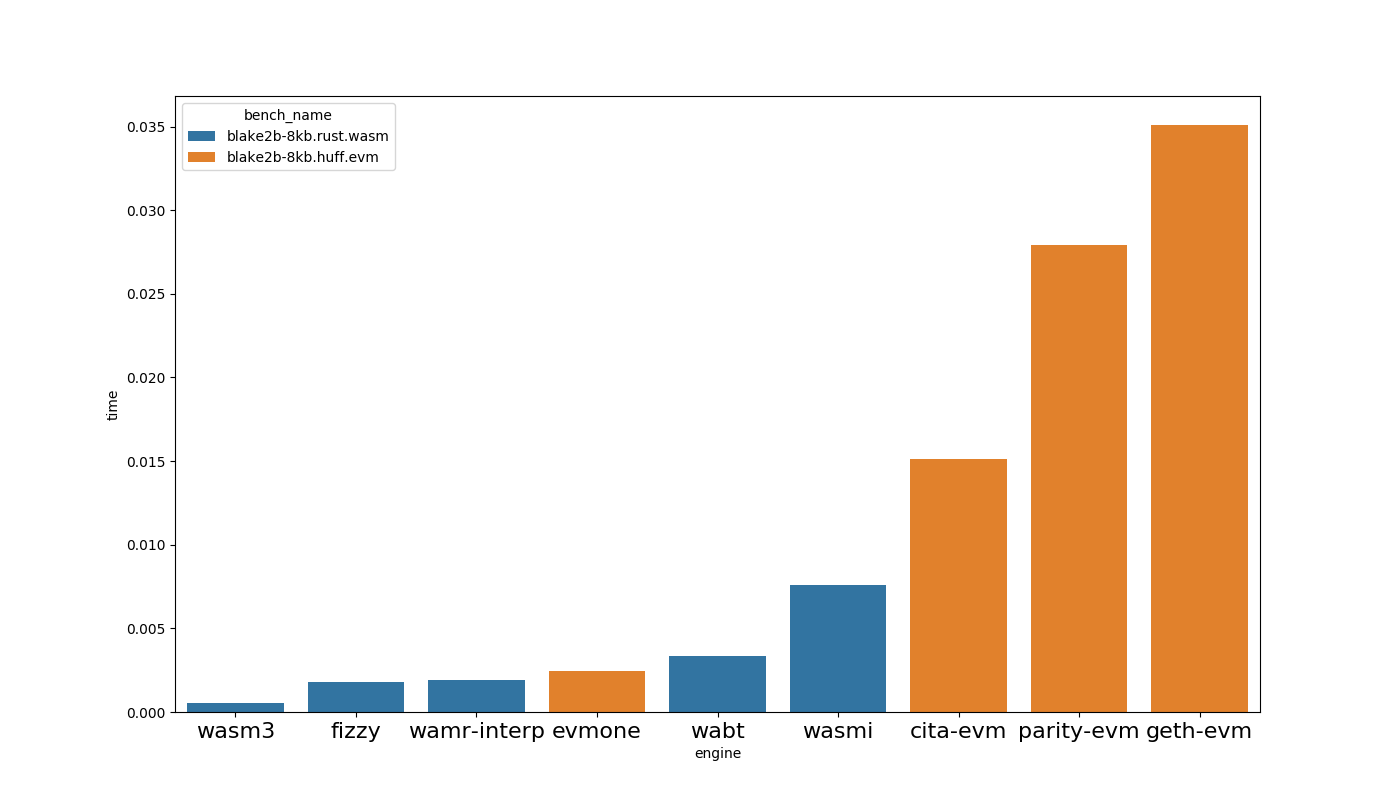

In [267]:
f = plt.figure(figsize=(14,8))
#sns.set()
#sns.reset_defaults()
#sns.set(font_scale = 1.2)
b = sns.barplot(x='engine', y='time', hue='bench_name', dodge=False,
            #hue_order=['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm'],
            #hue_order=['blake2b-8kb.rust.wasm', 'blake2b-8kb.huff.evm'],
            #order=['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm'],
            #order='exec_time',
            #order=[""]
            data=df_evm_vs_wasm_blake2b_sorted)

b.set_xticklabels(b.get_xticklabels(), size = 16)

Text(0.5, 0.95, 'EVM vs Wasm interpreters: BLAKE2b-8415-bytes')

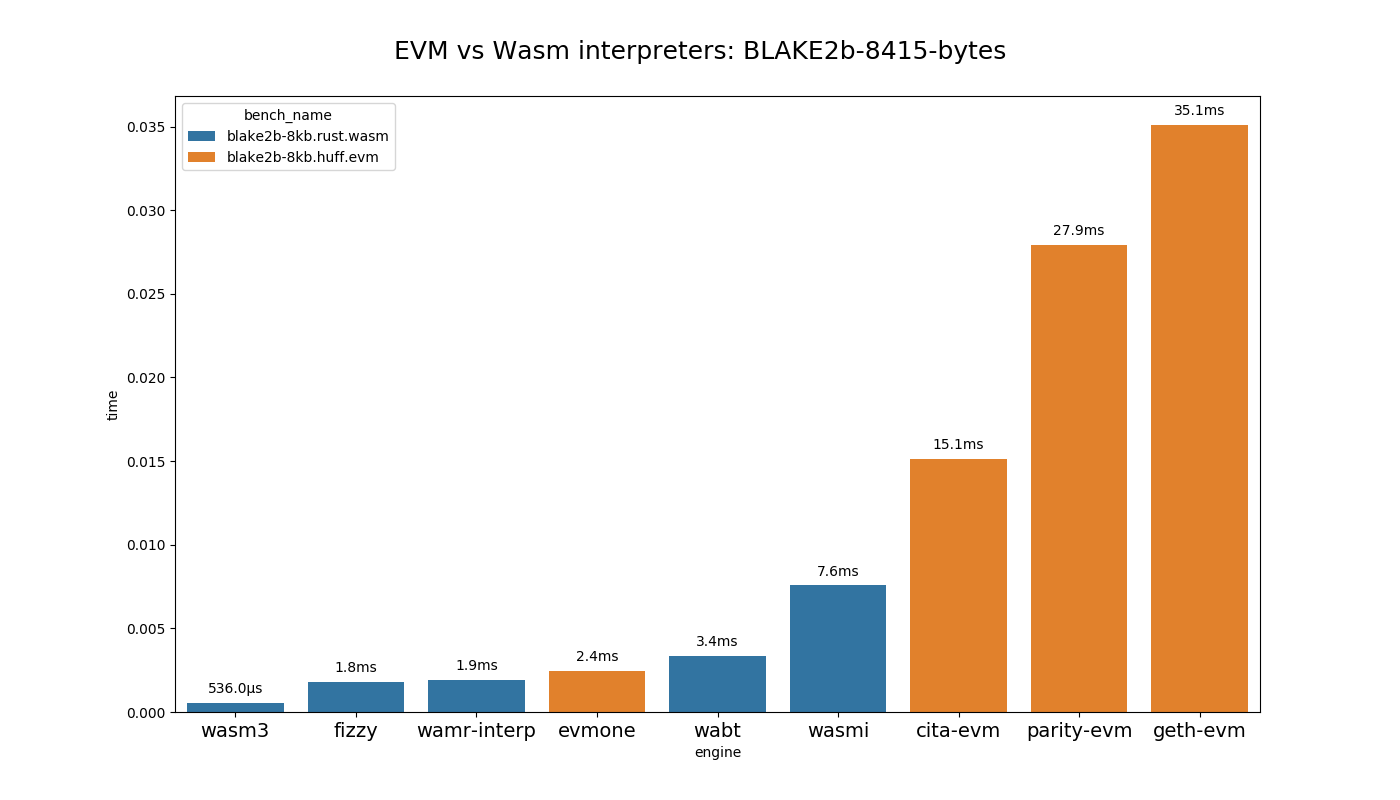

In [282]:
f = plt.figure(figsize=(14,8))
#sns.set()
#sns.reset_defaults()
#sns.set(font_scale = 1.2)
splot = sns.barplot(x='engine', y='time', hue='bench_name', dodge=False,
            #hue_order=['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm'],
            #hue_order=['blake2b-8kb.rust.wasm', 'blake2b-8kb.huff.evm'],
            #order=['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm'],
            #order='exec_time',
            #order=[""]
            data=df_evm_vs_wasm_blake2b_sorted)


# annotating bars: https://github.com/mwaskom/seaborn/issues/1582
for p in splot.patches:
    splot.annotate(
                   #format(p.get_height(), '.4f'),
                   toMs(p.get_height()),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 10),
                   textcoords = 'offset points')

splot.set_xticklabels(splot.get_xticklabels(), size = 14)

f.suptitle("EVM vs Wasm interpreters: BLAKE2b-8415-bytes", fontsize=18, y=0.95)


## Try EVM vs wasm shootout again, but use more grouped bars.

In [ ]:
df_evm_blake2b = df_evm_raw[df_evm_raw['test_name'].isin(['blake2b-8415-bytes', 'blake2b_huff-8415-bytes'])].copy()

df_evm_blake2b.rename(columns={'test_name':'bench_name', 'total_time':'exec_time'},inplace=True)
df_evm_blake2b.drop(['gas_used'],axis=1,inplace=True)
df_evm_blake2b.loc[:, 'parse_time'] = 0
df_evm_blake2b = df_evm_blake2b[['engine', 'bench_name', 'parse_time', 'exec_time']]

df_evm_blake2b.replace('blake2b-8415-bytes', 'blake2b-8kb.sol.evm', inplace=True)
df_evm_blake2b.replace('blake2b_huff-8415-bytes', 'blake2b-8kb.huff.evm', inplace=True)


In [ ]:
df_wasm_blake2b = df_interp[df_interp['test_name'] == "blake2b-8415-bytes"].copy()

df_wasm_blake2b.rename(columns={'test_name':'bench_name'},inplace=True)
df_wasm_blake2b.drop(['elapsed_time'],axis=1,inplace=True)
df_wasm_blake2b.drop(['total_time'],axis=1,inplace=True)
#df_wasm_blake2b = df_wasm_blake2b[['engine', 'bench_name', 'parse_time', 'exec_time']]
df_wasm_blake2b.reset_index(inplace=True)
df_wasm_blake2b.replace('blake2b-8415-bytes', 'blake2b-8kb.rust.wasm', inplace=True)



In [ ]:
df_evm_vs_wasm_blake2b = df_evm_blake2b.append(df_wasm_blake2b, sort=False).copy()

In [ ]:
df_evm_vs_wasm_blake2b = df_evm_vs_wasm_blake2b[df_evm_vs_wasm_blake2b['engine'].isin(
    ['parity-evm', 'geth-evm', 'evmone', 'cita-evm',
    'wasmi', 'wabt', 'wamr-interp', 'fizzy', 'wasm3']
)].copy()

In [ ]:
plotInterpThreeTests(df_interp,
                     blake2b_test_names,
                     title="wasm interpreters compared - blake2b",
                     filter_engines=["life", "wagon", "v8-interpreter"])